# Rubin Class Final Project
For my final project I aim to test a potentially improved NEO classification score that augments `digest2`.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
import ipywidgets as widgets
from matplotlib.patches import Patch

import difi
import thor

import variant_orbits
import scheduling
import detection_probability
import magnitudes

In [3]:
plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

%config InlineBackend.figure_format = 'retina'

# Read data

First we can get the first year of observations for both NEOs and MBAs in LSST.

In [6]:
%%time
obs_dfs = [pd.read_hdf(f"../current_criteria/old_not_hybrid_data/neo/filtered_visit_scores_{i:03d}.h5")
            for i in range(24)]
neo_obs = pd.concat(obs_dfs)
neo_obs = neo_obs[neo_obs["n_obs"] >= 3]

CPU times: user 840 ms, sys: 143 ms, total: 982 ms
Wall time: 994 ms


In [7]:
%%time
obs_dfs = [pd.read_hdf(f"../current_criteria/old_not_hybrid_data/mba/filtered_visit_scores_{i:03d}.h5").sort_values("FieldMJD")
            for i in range(24)]
mba_obs = pd.concat(obs_dfs)
mba_obs = mba_obs[mba_obs["n_obs"] >= 3]

CPU times: user 2min 33s, sys: 1min 1s, total: 3min 34s
Wall time: 3min 49s


# Magnitudes

Now we can convert the magnitudes to each filter to an apparent magnitude.

In [6]:
def get_v_mag(obs):
    v_mag = np.ones(len(obs)) * np.inf
    for filter_letter in "ugrizy":
        filter_mask = obs["filter"] == filter_letter
        if filter_mask.any():
            v_mag[filter_mask] = magnitudes.convert_colour_mags(obs[filter_mask]["MaginFilter"],
                                                                out_colour=filter_letter,
                                                                in_colour="V", convention="LSST",
                                                                asteroid_type="C")
    obs["v_mag"] = v_mag
    return v_mag

In [7]:
%%time
get_v_mag(neo_obs)

CPU times: user 76 ms, sys: 10 ms, total: 86 ms
Wall time: 85.1 ms


array([23.98769782, 23.8982874 , 23.22709289, ..., 22.50555654,
       22.55979623, 22.48042325])

In [8]:
%%time
get_v_mag(mba_obs)

CPU times: user 28.8 s, sys: 9.74 s, total: 38.5 s
Wall time: 38 s


array([23.13466705, 24.35898058, 24.4354543 , ..., 19.26034355,
       20.36828243, 20.49152702])

# Ecliptic coordinates

In [8]:
epsilon = 23.4392811*np.pi/180 #obliquity
def to_ecliptic(obs):
    '''
    For a given :math:`(\\alpha,\\delta)` (RA, DEC) measurement, finds the corresponding :math:`(b,\\ell)` angle
    '''
    alpha, delta = np.deg2rad(obs["AstRA(deg)"]), np.deg2rad(obs["AstDec(deg)"])
    b = np.rad2deg(np.arcsin(np.cos(epsilon) * np.sin(delta) - np.sin(epsilon) * np.cos(delta) * np.sin(alpha)))
    l = np.rad2deg(np.arctan2((np.cos(epsilon) * np.cos(delta) * np.sin(alpha) + np.sin(epsilon) * np.sin(delta)), (np.cos(delta) * np.cos(alpha))))
    
    obs["ecl_lat"] = b
    obs["ecl_lon"] = l
    
    return b.values, l.values

In [9]:
%%time
to_ecliptic(neo_obs)

CPU times: user 35.9 ms, sys: 7.36 ms, total: 43.3 ms
Wall time: 41.6 ms


(array([-44.98188999, -44.98211336, -44.9843487 , ..., -10.71544663,
        -10.70982142, -10.70975948]),
 array([-152.26060503, -152.26093007, -152.26378315, ..., -166.40207055,
        -166.39165456, -166.39144796]))

In [10]:
%%time
to_ecliptic(mba_obs)

CPU times: user 13.8 s, sys: 8.69 s, total: 22.5 s
Wall time: 17 s


(array([-60.88538564, -61.17135071, -61.17139127, ...,  15.06658641,
         13.9921269 ,  12.35090766]),
 array([ 132.01475839,  132.90390386,  132.90392427, ..., -150.35070484,
        -151.33561128, -152.66905754]))

# Direction of motion

In [21]:
def angle_from_ecliptic(df):
    first, last = df.iloc[0], df.iloc[-1]
    init = SkyCoord(lon=first["ecl_lon"], lat=first["ecl_lat"],
                    unit="deg", frame="heliocentriceclipticiau76")
    final = SkyCoord(lon=last["ecl_lon"], lat=last["ecl_lat"],
                     unit="deg", frame="heliocentriceclipticiau76")
    
    dlon, dlat = init.spherical_offsets_to(final)
    return np.arctan(dlat / dlon).to(u.rad).value

In [20]:
%%time
neo_directions = neo_obs.groupby(by=["ObjID", "night"]).apply(angle_from_ecliptic)

NameError: name 'angle_from_ecliptic' is not defined

In [ ]:
%%time
mba_directions = mba_obs.groupby(by=["ObjID", "night"]).apply(angle_from_ecliptic)
np.save("dont_lose_these.npy", mba_directions.reset_index().sort_values(by=["night", "ObjID"])[0].values)

# Tracklet speed

In [12]:
def tracklet_speed(df):
    first, last = df.iloc[0], df.iloc[-1]
    init = SkyCoord(ra=first["AstRA(deg)"], dec=first["AstDec(deg)"],
                    unit="deg", frame="icrs")
    final = SkyCoord(ra=last["AstRA(deg)"], dec=last["AstDec(deg)"],
                     unit="deg", frame="icrs")
    
    sep = init.separation(final).to(u.deg).value
    dt = (last["FieldMJD"] - first["FieldMJD"])
    return sep / dt

In [13]:
%%time
neo_speeds = neo_obs.groupby(by=["ObjID", "night"]).apply(tracklet_speed)

CPU times: user 1min 41s, sys: 2.51 s, total: 1min 43s
Wall time: 1min 43s


In [15]:
np.save("neo_speeds.npy", neo_speeds.reset_index().sort_values(by=["night", "ObjID"])[0].values)
neo_speeds_flat = np.load("neo_speeds.npy")

In [ ]:
%%time
mba_speeds = mba_obs.groupby(by=["ObjID", "night"]).apply(tracklet_speed)
np.save("mba_speeds.npy", mba_speeds.reset_index().sort_values(by=["night", "ObjID"])[0].values)

In [14]:
# mba_speeds_flat = mba_speeds.reset_index().sort_values(by=["night", "ObjID"])[0].values
mba_speeds_flat = np.load("mba_speeds.npy")

# De-duplicate

In [11]:
%%time
neo_obs_dd = neo_obs.drop_duplicates(subset=["ObjID", "night"]).sort_values(by=["night", "ObjID"])
mba_obs_dd = mba_obs.drop_duplicates(subset=["ObjID", "night"]).sort_values(by=["night", "ObjID"])

CPU times: user 58.5 s, sys: 9.12 s, total: 1min 7s
Wall time: 1min 7s


In [19]:
neo_obs_dd["direction"] = np.rad2deg(neo_directions.reset_index().sort_values(by=["night", "ObjID"])[0].values)

NameError: name 'neo_directions' is not defined

In [354]:
%%time
mba_obs_dd["direction"] = np.rad2deg(mba_directions.reset_index().sort_values(by=["night", "ObjID"])[0].values)

CPU times: user 1min 1s, sys: 9.89 s, total: 1min 11s
Wall time: 1min 11s


In [ ]:
%%time
mba_obs_dd["direction"] = np.rad2deg(np.load("dont_lose_these.npy"))

In [16]:
%%time
neo_obs_dd["ang_vel"] = neo_speeds_flat

CPU times: user 1.27 ms, sys: 92 µs, total: 1.36 ms
Wall time: 1.22 ms


In [17]:
%%time
mba_obs_dd["ang_vel"] = mba_speeds_flat

CPU times: user 20.5 ms, sys: 60.1 ms, total: 80.6 ms
Wall time: 76.1 ms


In [76]:
neo_obs_dd["log_ang_vel"] = np.log10(neo_obs_dd["ang_vel"])
mba_obs_dd["log_ang_vel"] = np.log10(mba_obs_dd["ang_vel"])

# Plotting

In [21]:
def compare_hists(var, label, ylabel, neo_obs, mba_obs,
                  bins="fd", density="both", figsize=(8, 16),
                  colours = {
                      "neo": list(plt.get_cmap("tab10")(1)),
                      "mba": list(plt.get_cmap("tab10")(4))
                  },
                  save_plot=None, apply_score_cut=False, apply_speed_cut=True):
    
    if apply_score_cut:
        neo_obs = neo_obs[neo_obs["scores"] >= 65]
        mba_obs = mba_obs[mba_obs["scores"] >= 65]
    if apply_speed_cut:
        neo_obs = neo_obs[neo_obs["ang_vel"] < 1.5]
        mba_obs = mba_obs[mba_obs["ang_vel"] < 1.5]
    
    neo_hist, var_bins = np.histogram(neo_obs[var], bins=bins, density=False)
    mba_hist, var_bins = np.histogram(mba_obs[var], bins=var_bins, density=False)

    handles = [Patch(facecolor=colours["neo"][:-1] + [0.2],
                         edgecolor=colours["neo"],
                         label="NEOs", lw=3),
               Patch(facecolor=colours["mba"][:-1] + [0.2],
                         edgecolor=colours["mba"],
                         label="MBAs", lw=3)]
    
    def _hists(ax, dens):
        ax.hist(neo_obs[var], bins=var_bins, density=dens, label="NEOs", facecolor=colours["neo"][:-1] + [0.2], lw=3)
        ax.hist(neo_obs[var], bins=var_bins, density=dens, color=colours["neo"], histtype="step", lw=3)

        ax.hist(mba_obs[var], bins=var_bins, density=dens, label="MBAs", facecolor=colours["mba"][:-1] + [0.2], lw=3)
        ax.hist(mba_obs[var], bins=var_bins, density=dens, color=colours["mba"], histtype="step", lw=3)
        ax.legend(handles=handles, loc="upper center", ncol=2, fontsize=0.8 * fs)

        if dens:
            ax.set_ylabel(r"$\mathrm{d}N/\mathrm{d}$" + ylabel)
        else:
            ax.set_yscale("log")
            ax.set_ylabel("Number of objects")
    
    if density == "both":
        fig, axes = plt.subplots(3, 1, figsize=figsize, gridspec_kw={"height_ratios": [2, 2, 1]}, sharex=True)
        for ax, dens in zip(axes[:-1], [True, False]):
            _hists(ax, dens)
    else:
        fig, axes = plt.subplots(2, 1, figsize=figsize, gridspec_kw={"height_ratios": [2, 1]}, sharex=True)
        _hists(axes[0], density)
    
    centres = (var_bins[1:] + var_bins[:-1]) / 2
    axes[-1].plot(centres[mba_hist > 0], neo_hist[mba_hist > 0] / mba_hist[mba_hist > 0], marker="o")
    centres = (var_bins[1:] + var_bins[:-1]) / 2
    axes[-1].scatter(centres[mba_hist <= 0],
                     np.repeat(max(neo_hist[mba_hist > 0] / mba_hist[mba_hist > 0]), (mba_hist <= 0).sum()),
                     marker=r"$\infty$", color="tab:blue", zorder=10)
    axes[-1].set_yscale("log")
    axes[-1].set_xlabel(label)
    axes[-1].set_ylabel(r"$N_{\rm NEO}/N_{\rm MBA}$")
    axes[-1].grid()
    
    if np.any(neo_hist[mba_hist > 0] / mba_hist[mba_hist > 0] >= 1.0):
        axes[-1].axhline(1.0, linestyle="dotted", color="grey")
        
    for ax in axes[:-1]:
        ax.xaxis.set_tick_params(which='both', labelbottom=True)
        
    axes[0].annotate("a", xy=(0.02, 0.98), xycoords="axes fraction", fontsize=0.5*fs, va="top",
                     bbox=dict(boxstyle="circle", facecolor="lightgrey", edgecolor="none"))
    axes[1].annotate("b", xy=(0.98, 0.98), xycoords="axes fraction", fontsize=0.5*fs, va="top", ha="right",
                     bbox=dict(boxstyle="circle", facecolor="lightgrey", edgecolor="none"))
    axes[2].annotate("c", xy=(0.02, 0.96), xycoords="axes fraction", fontsize=0.5*fs, va="top",
                     bbox=dict(boxstyle="circle", facecolor="lightgrey", edgecolor="none"))    
        
    if save_plot is not None:
        plt.savefig(save_plot, format="pdf", bbox_inches="tight")

    plt.show()

# Plot for Matt

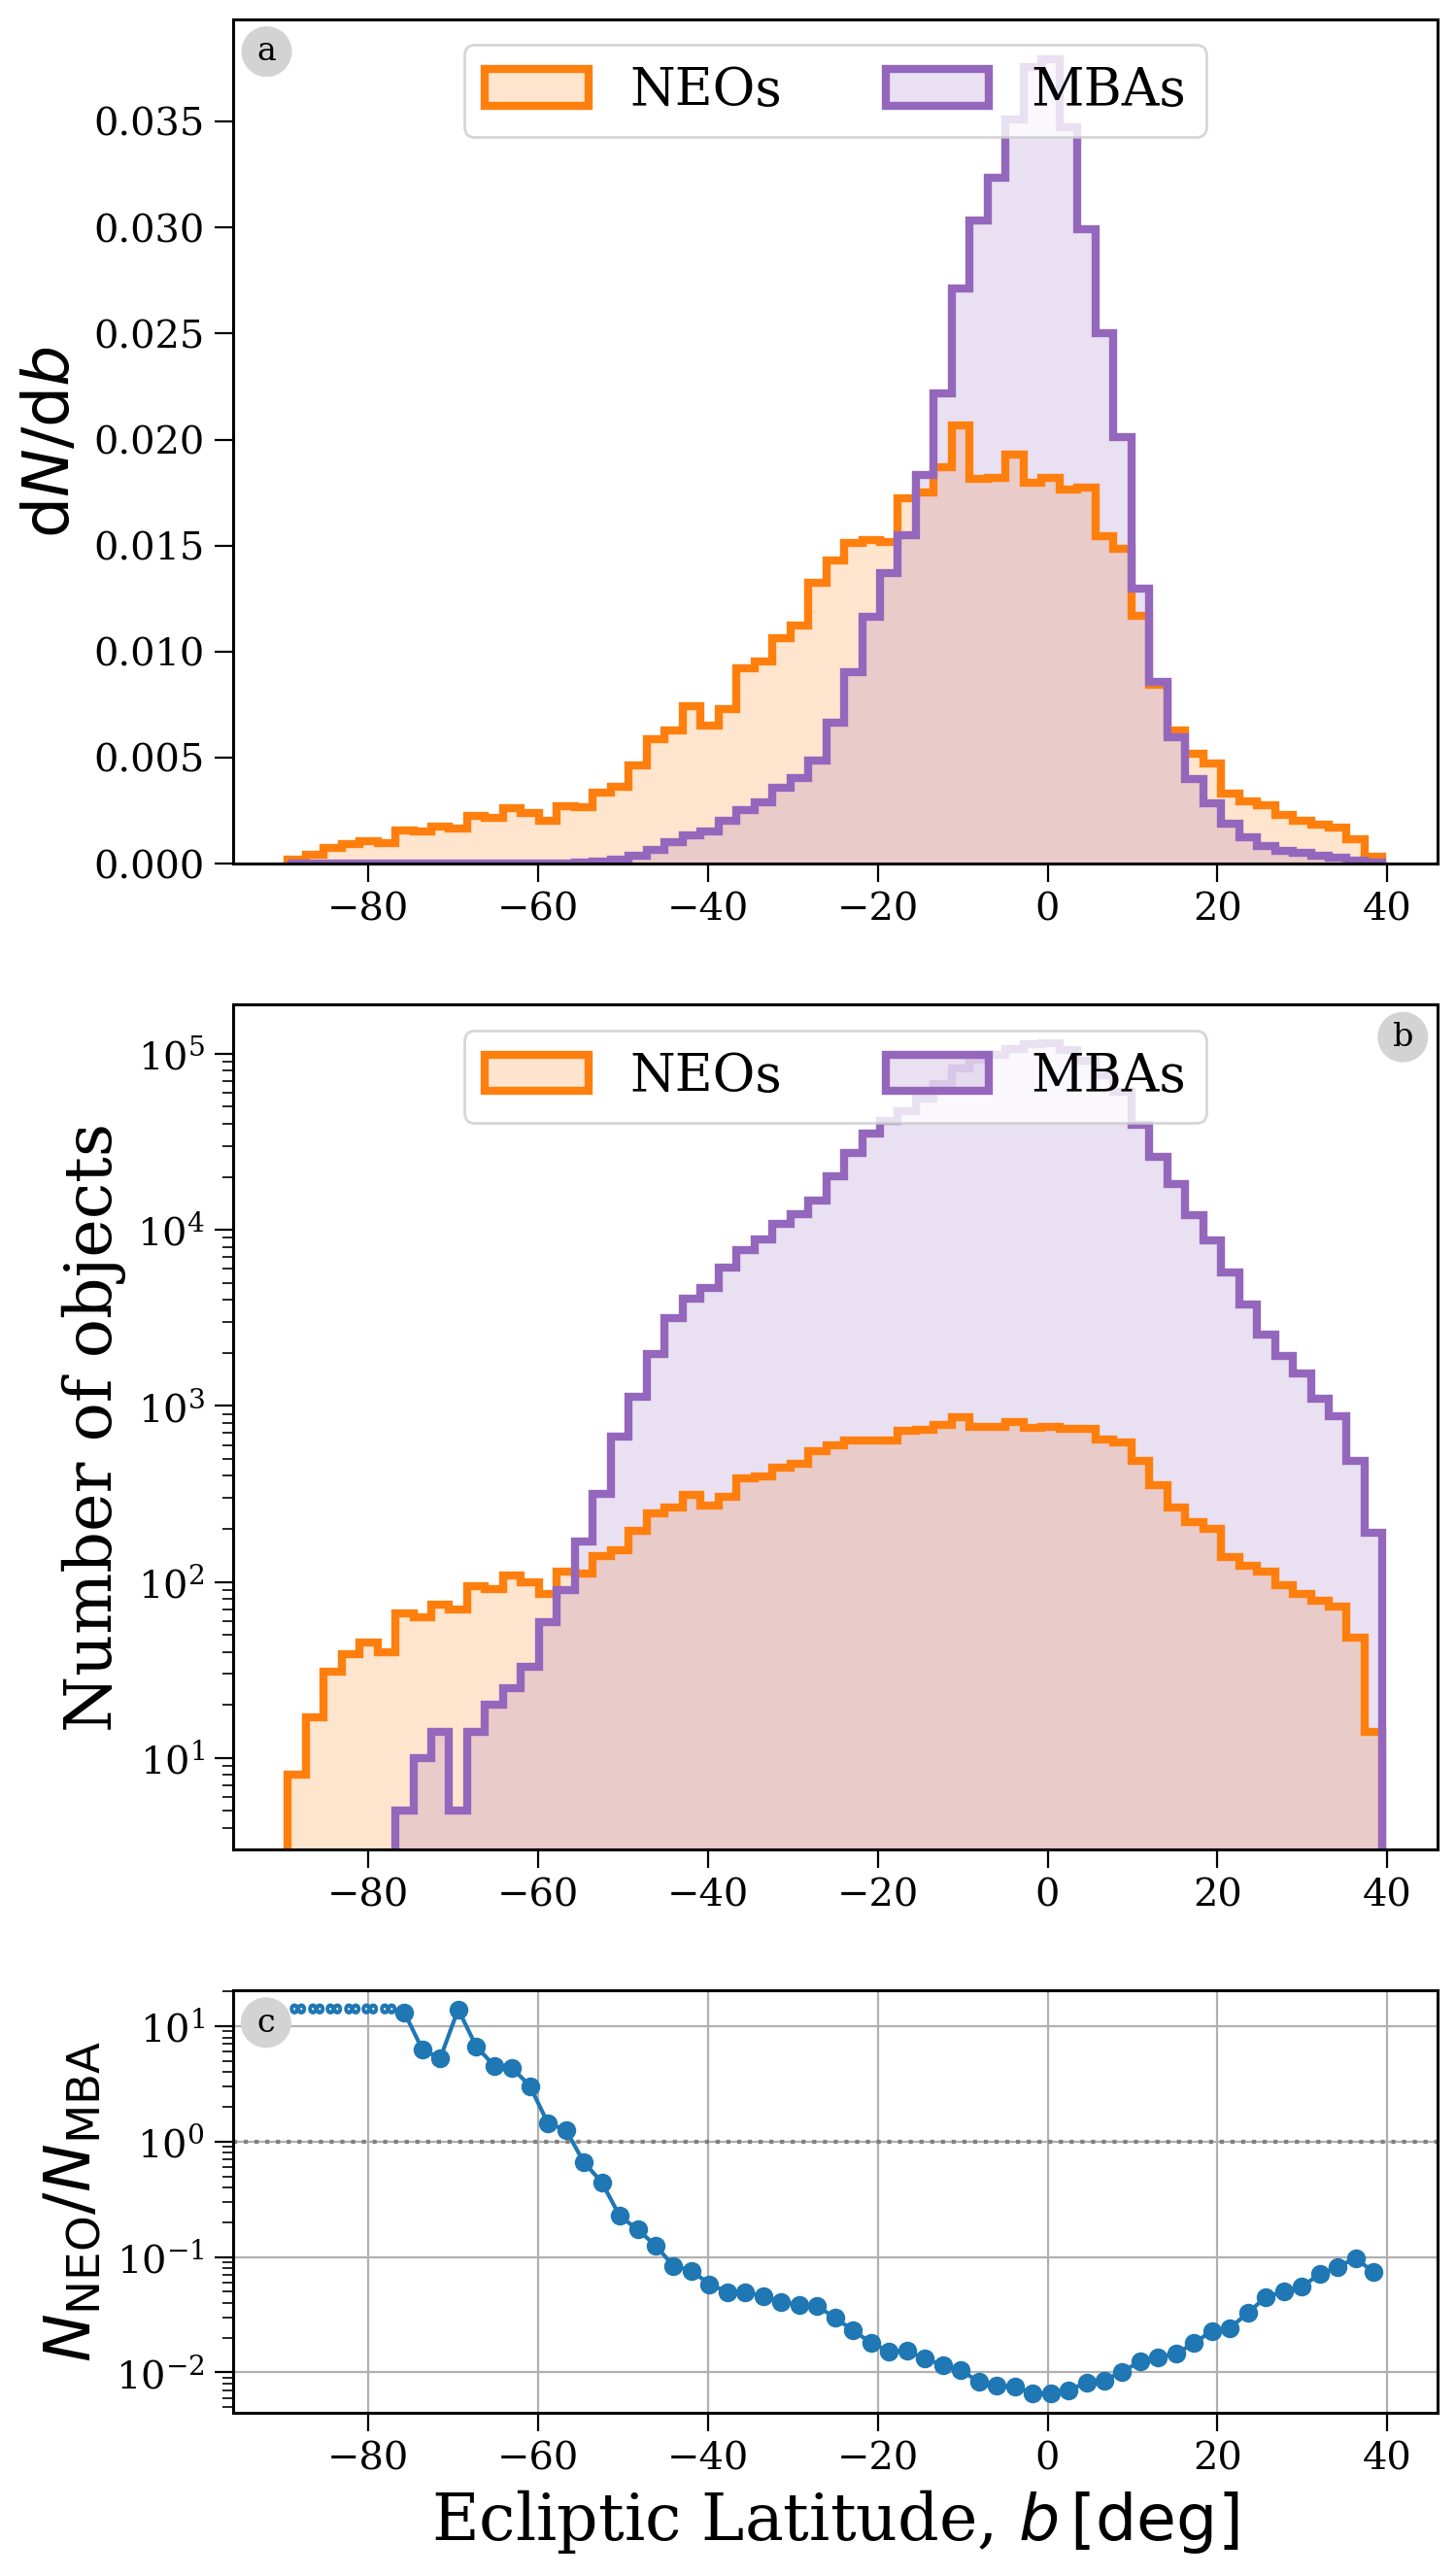

In [23]:
compare_hists("ecl_lat", r"Ecliptic Latitude, $b \, [\rm deg]$", r"$b$",
              neo_obs_dd, mba_obs_dd, apply_score_cut=True)

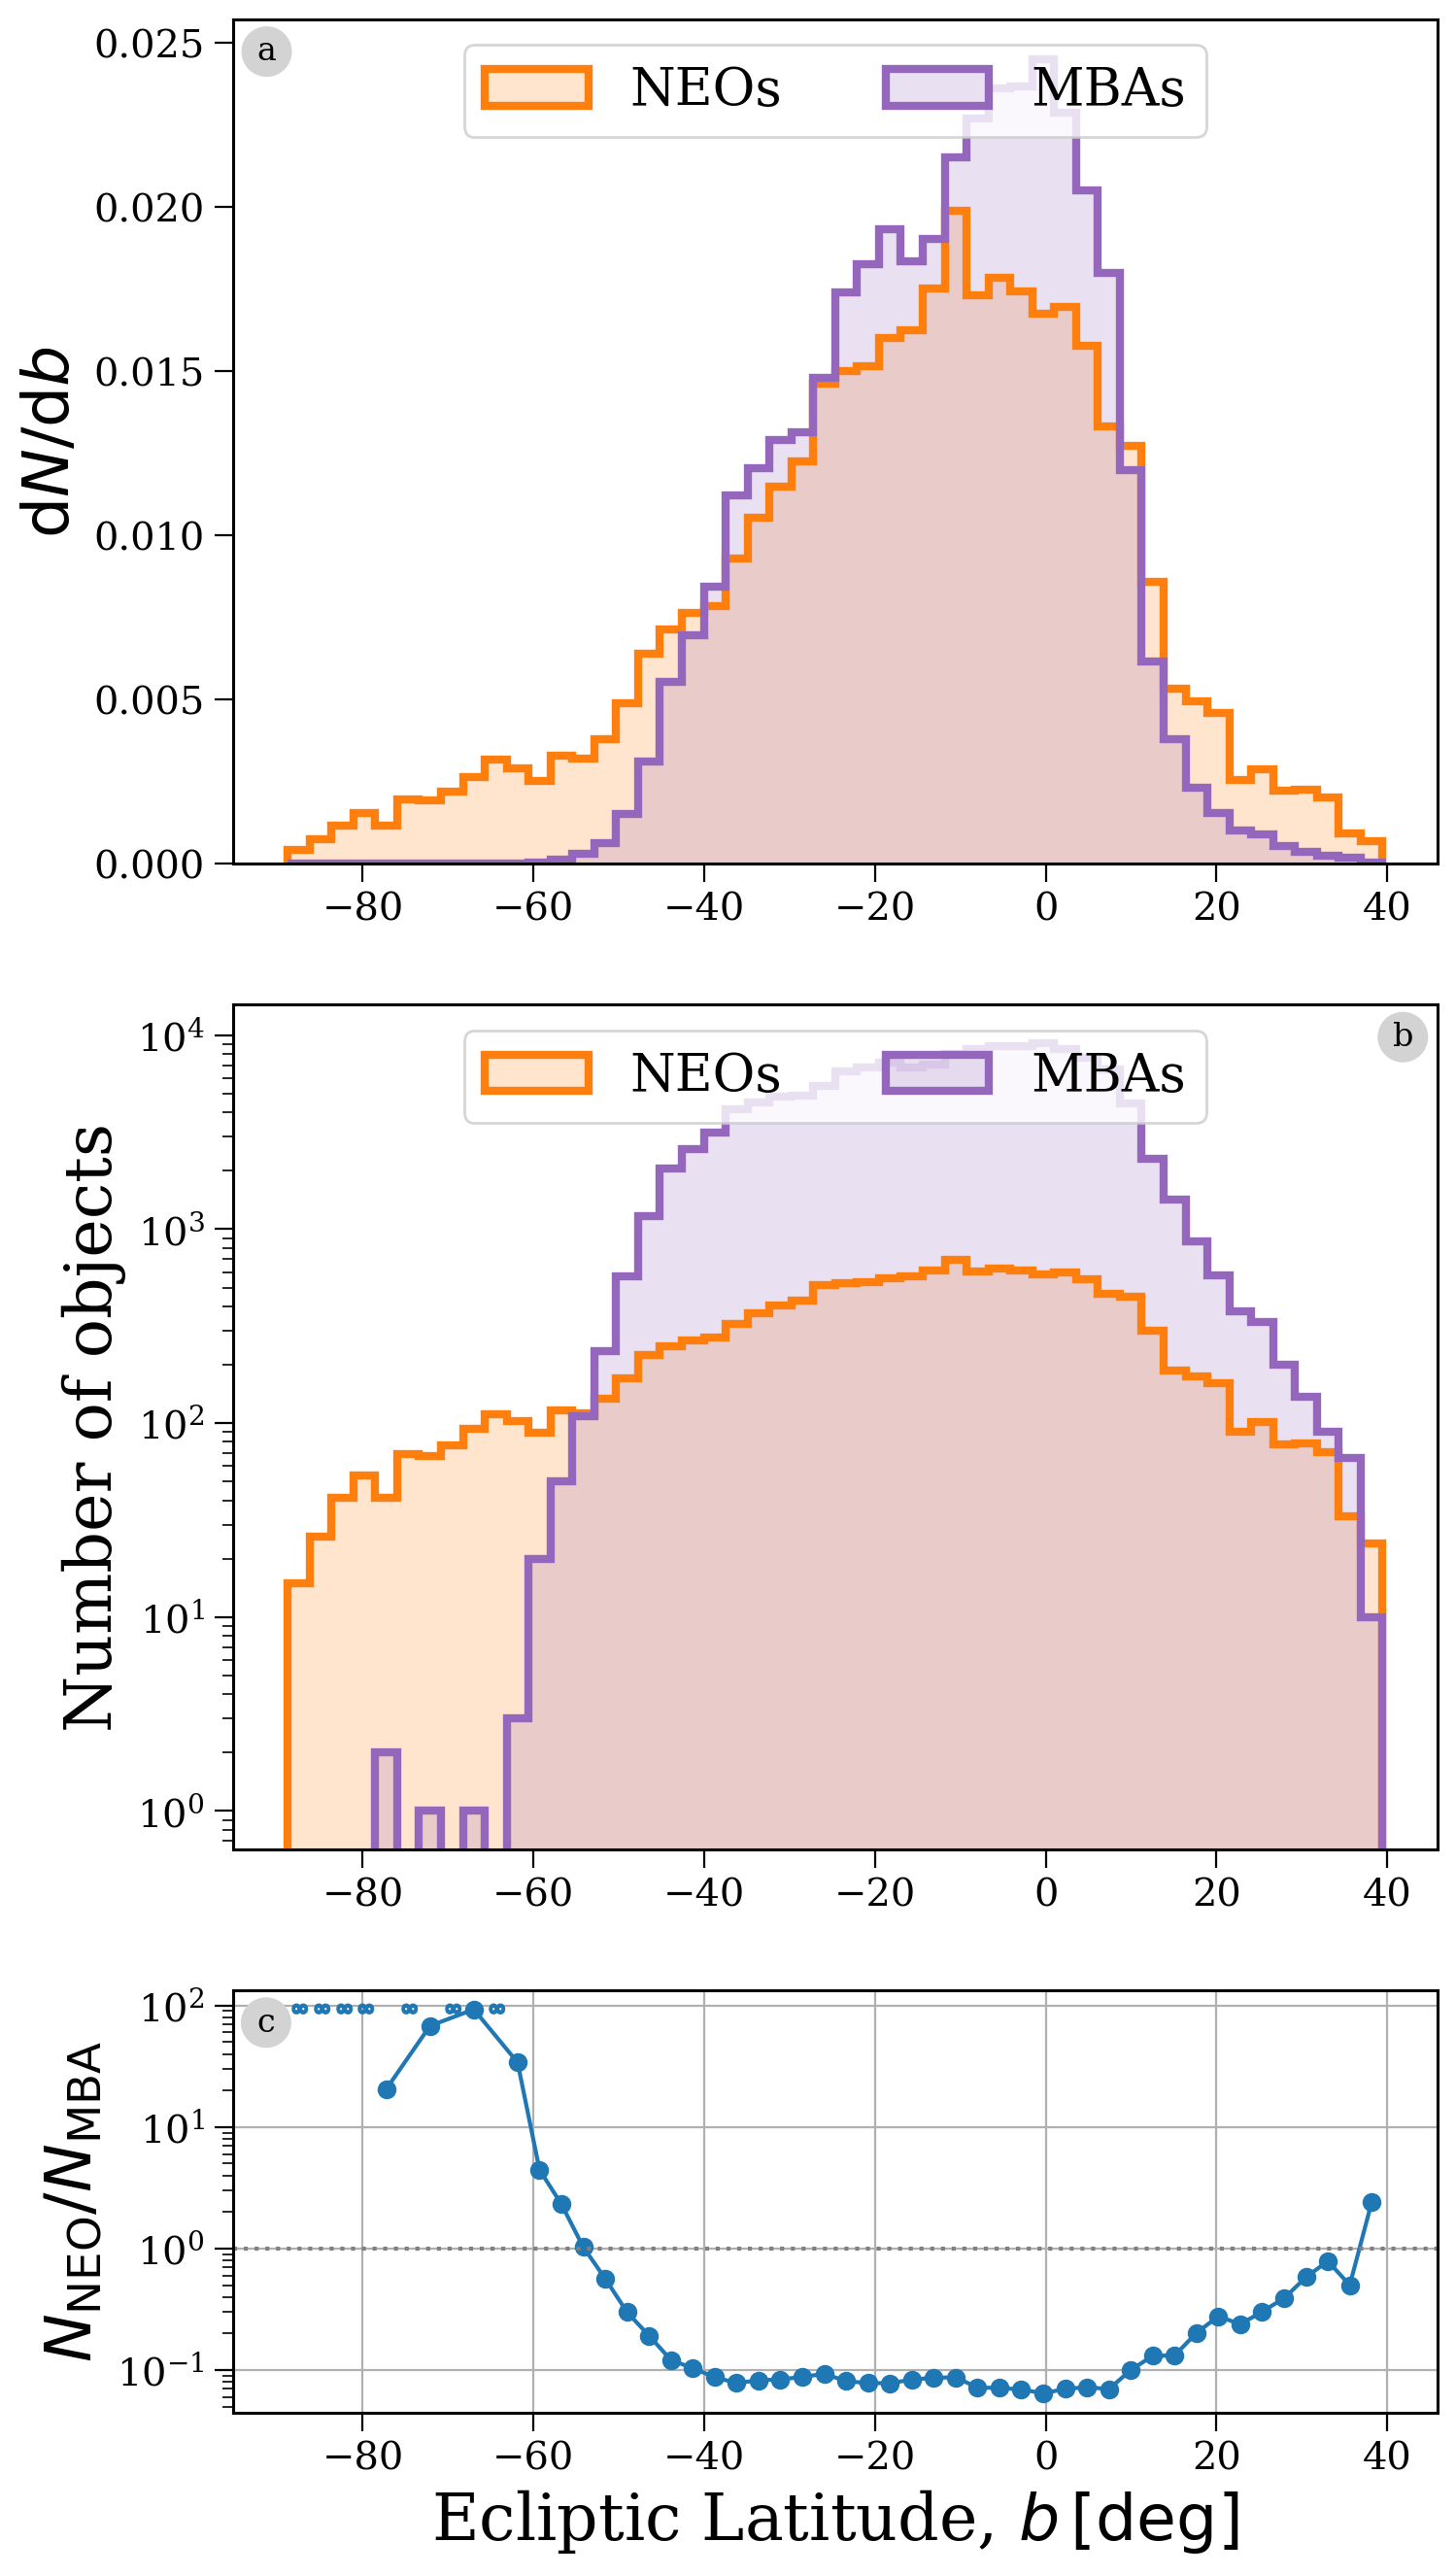

In [20]:
compare_hists("ecl_lat", r"Ecliptic Latitude, $b \, [\rm deg]$", r"$b$",
              neo_obs_dd, mba_obs_dd, apply_score_cut=True)

<hr>

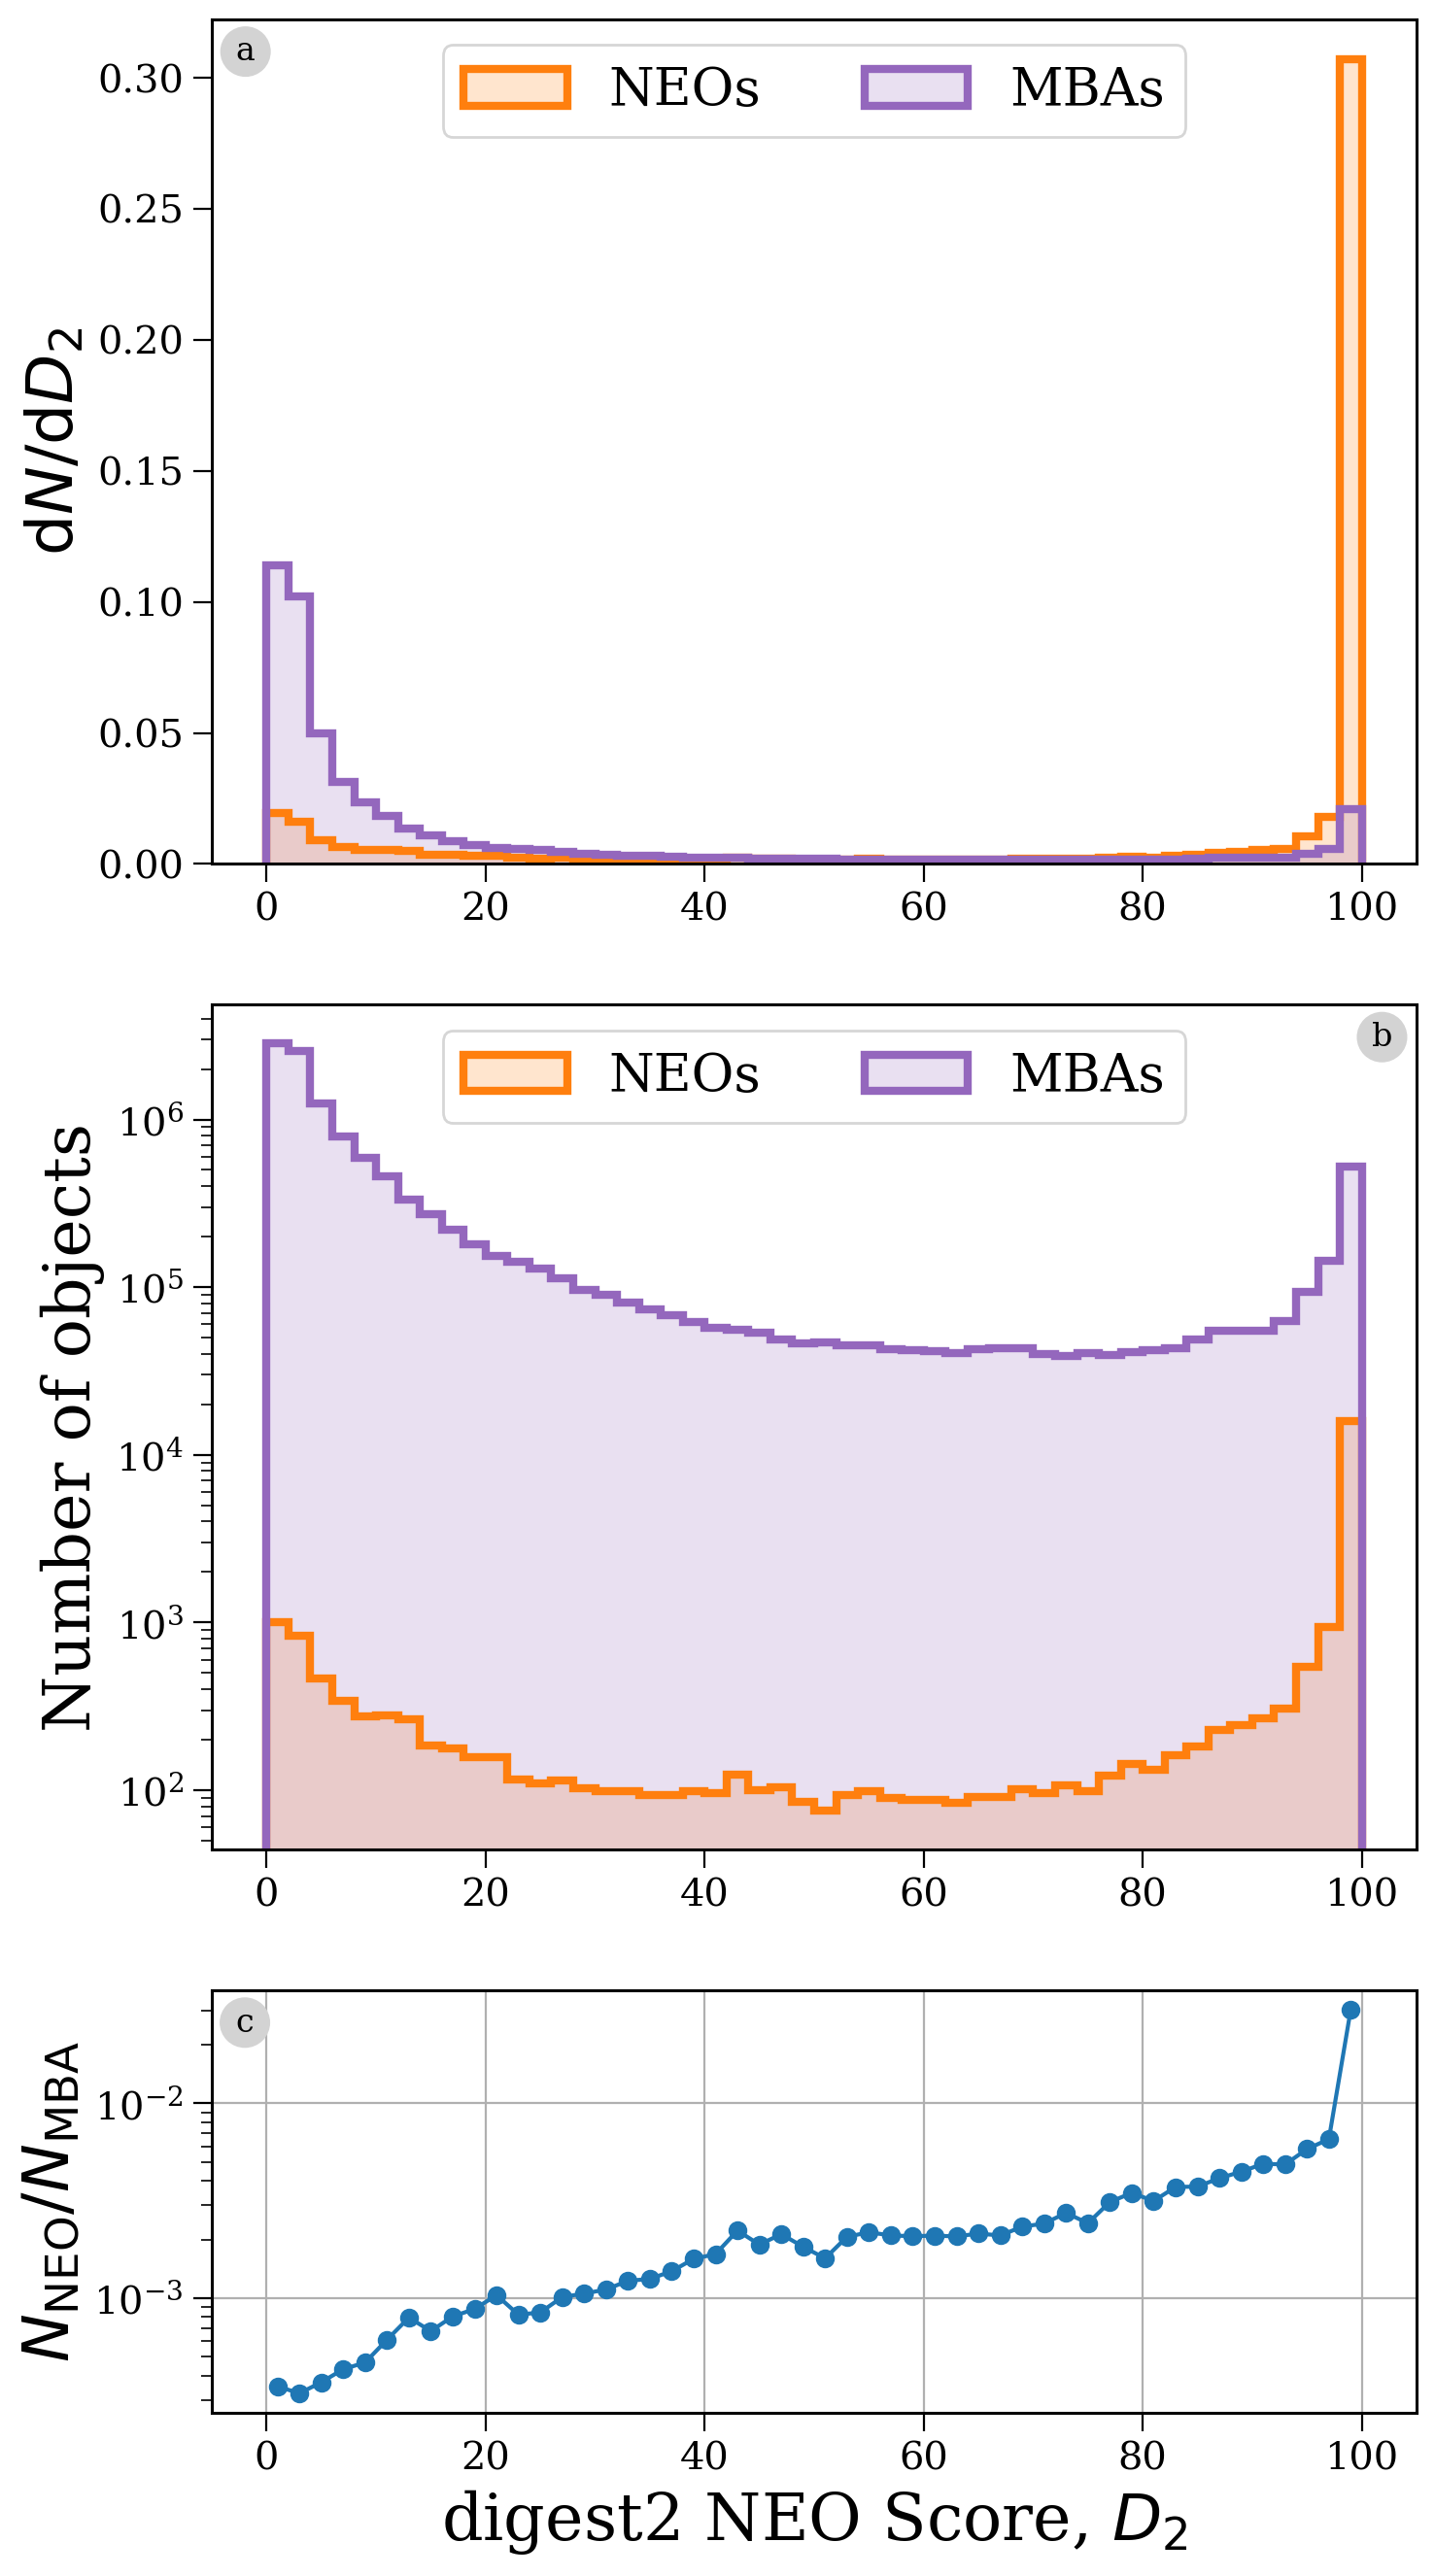

In [150]:
compare_hists("scores", r"digest2 NEO Score, $D_2$", r"$D_2$", neo_obs_dd, mba_obs_dd,
              density="both", bins=np.linspace(0, 100, 51), figsize=(8, 16),
              save_plot="../paper/figures/digest2_pollution.pdf")

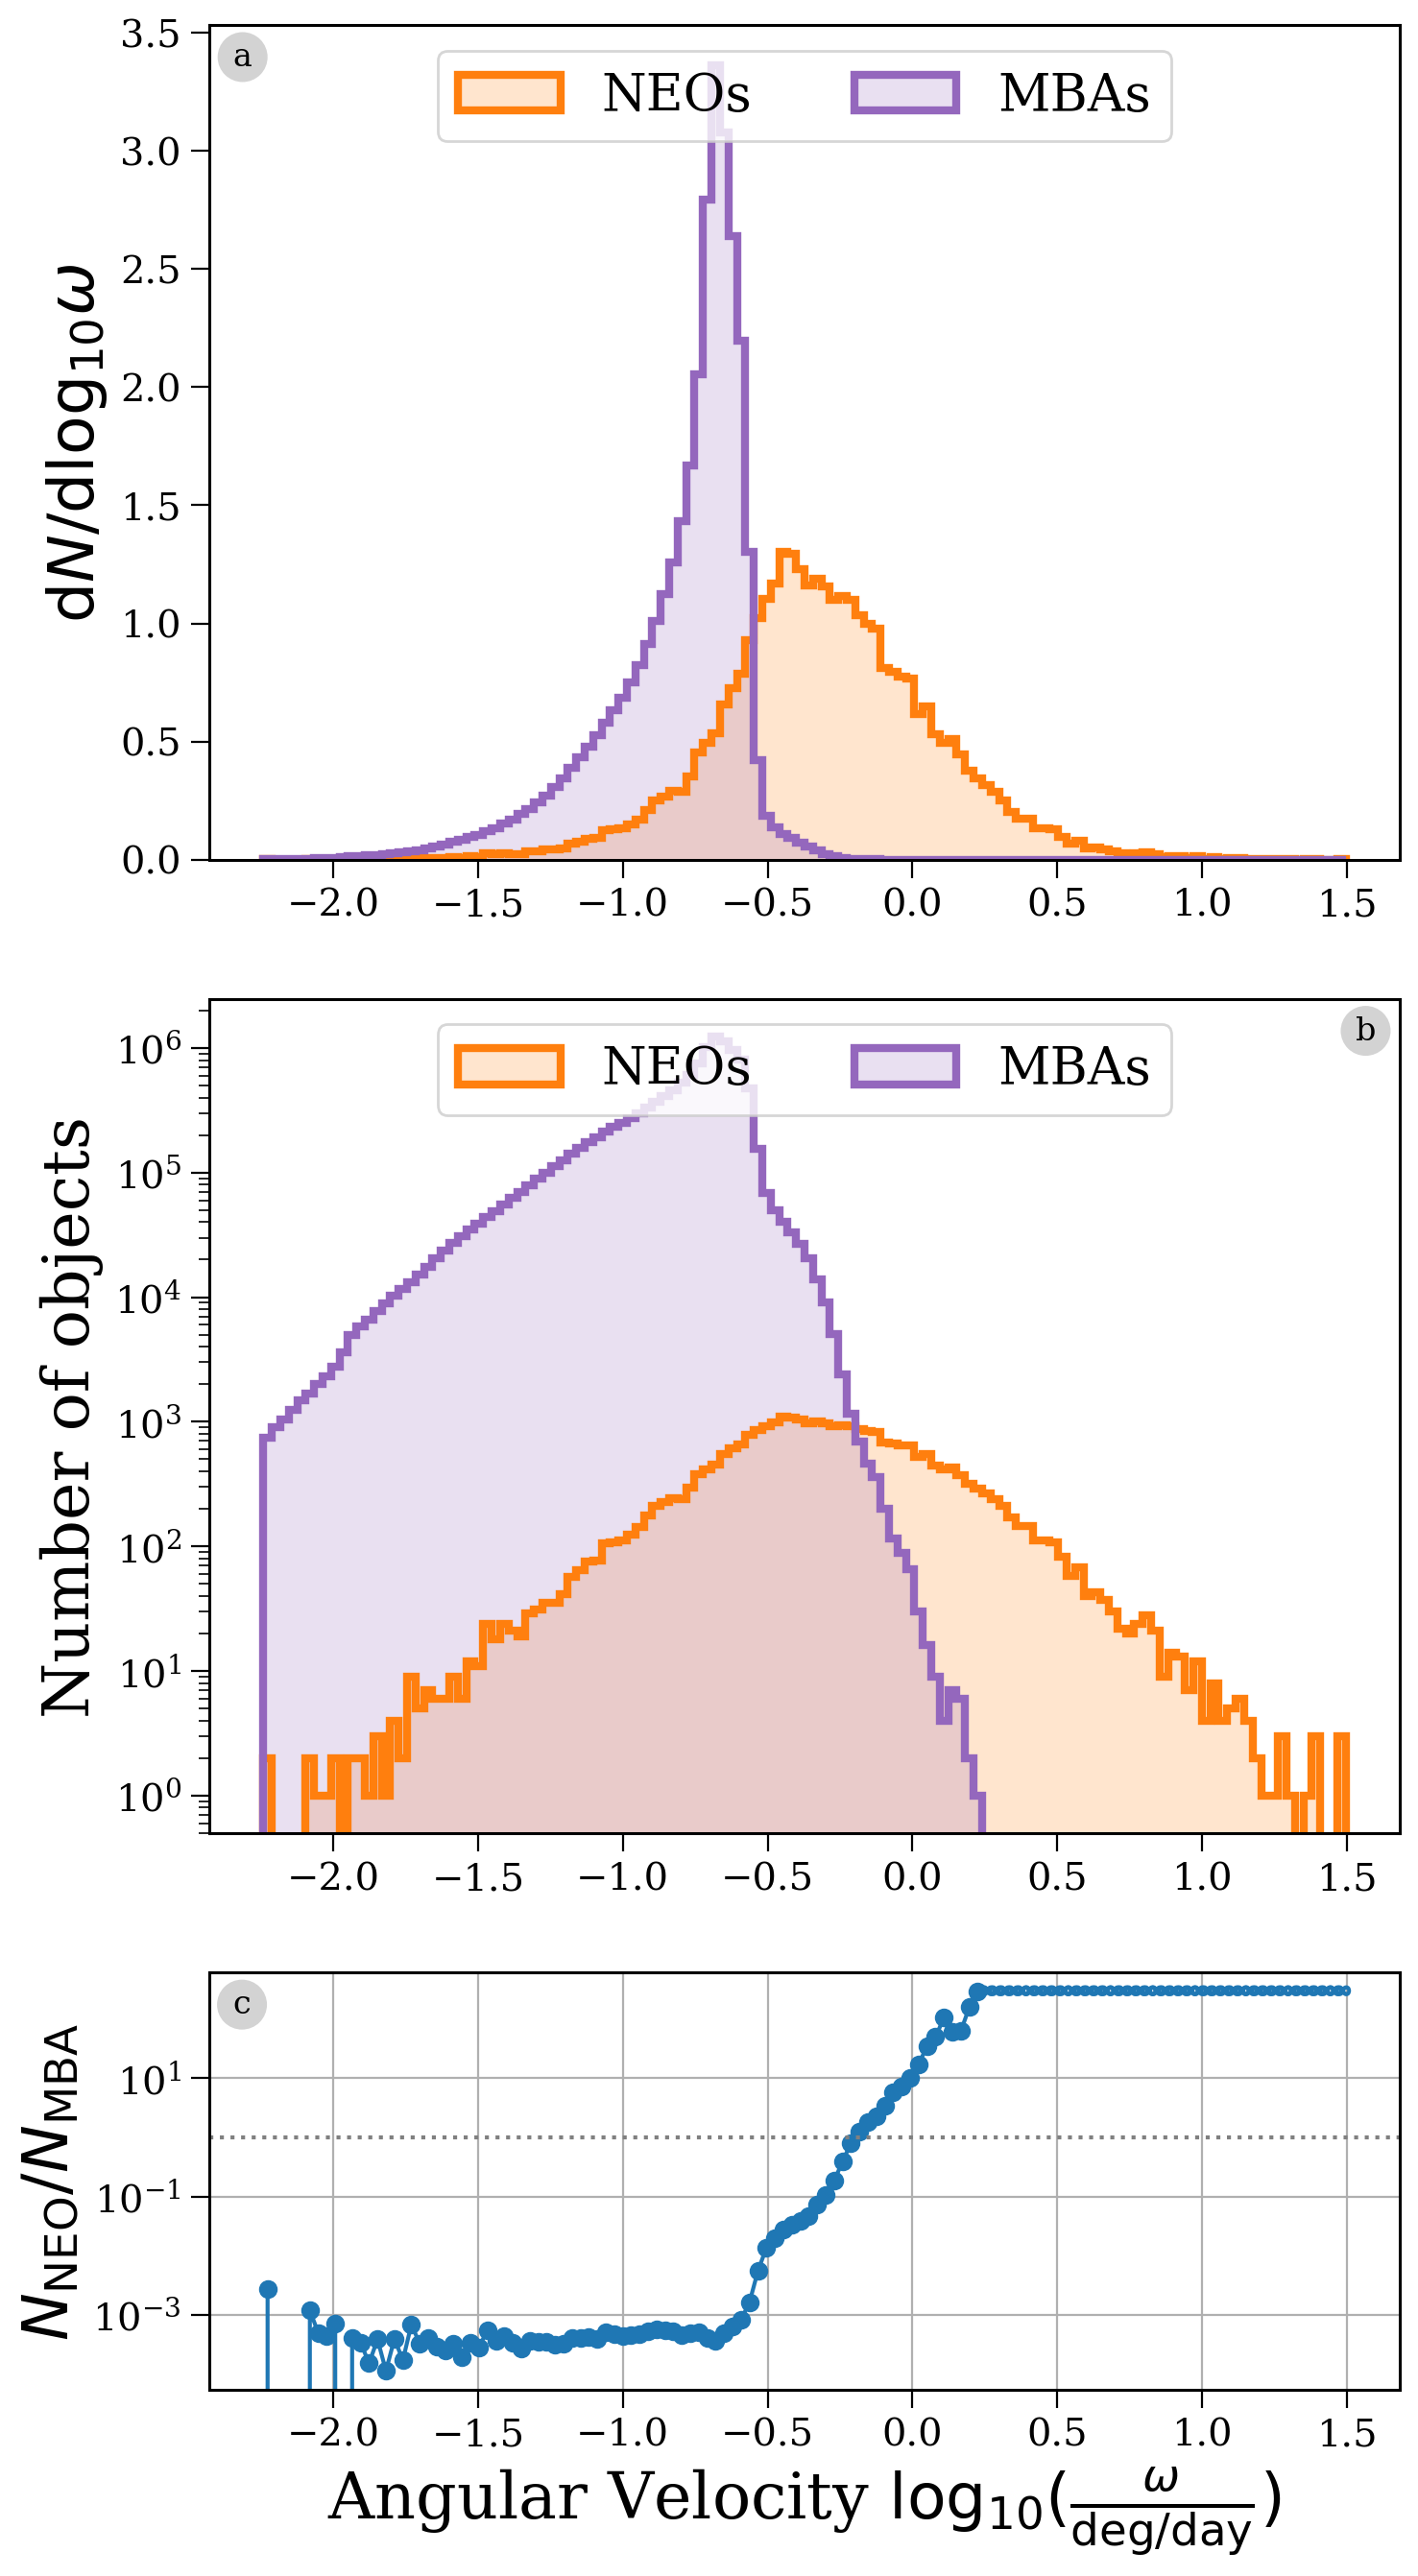

In [77]:
compare_hists("log_ang_vel", r"Angular Velocity $\log_{10}(\frac{\omega}{\rm deg / day})$", r"$\log_{10} \omega$", neo_obs_dd, mba_obs_dd,
              density="both", figsize=(8, 16))

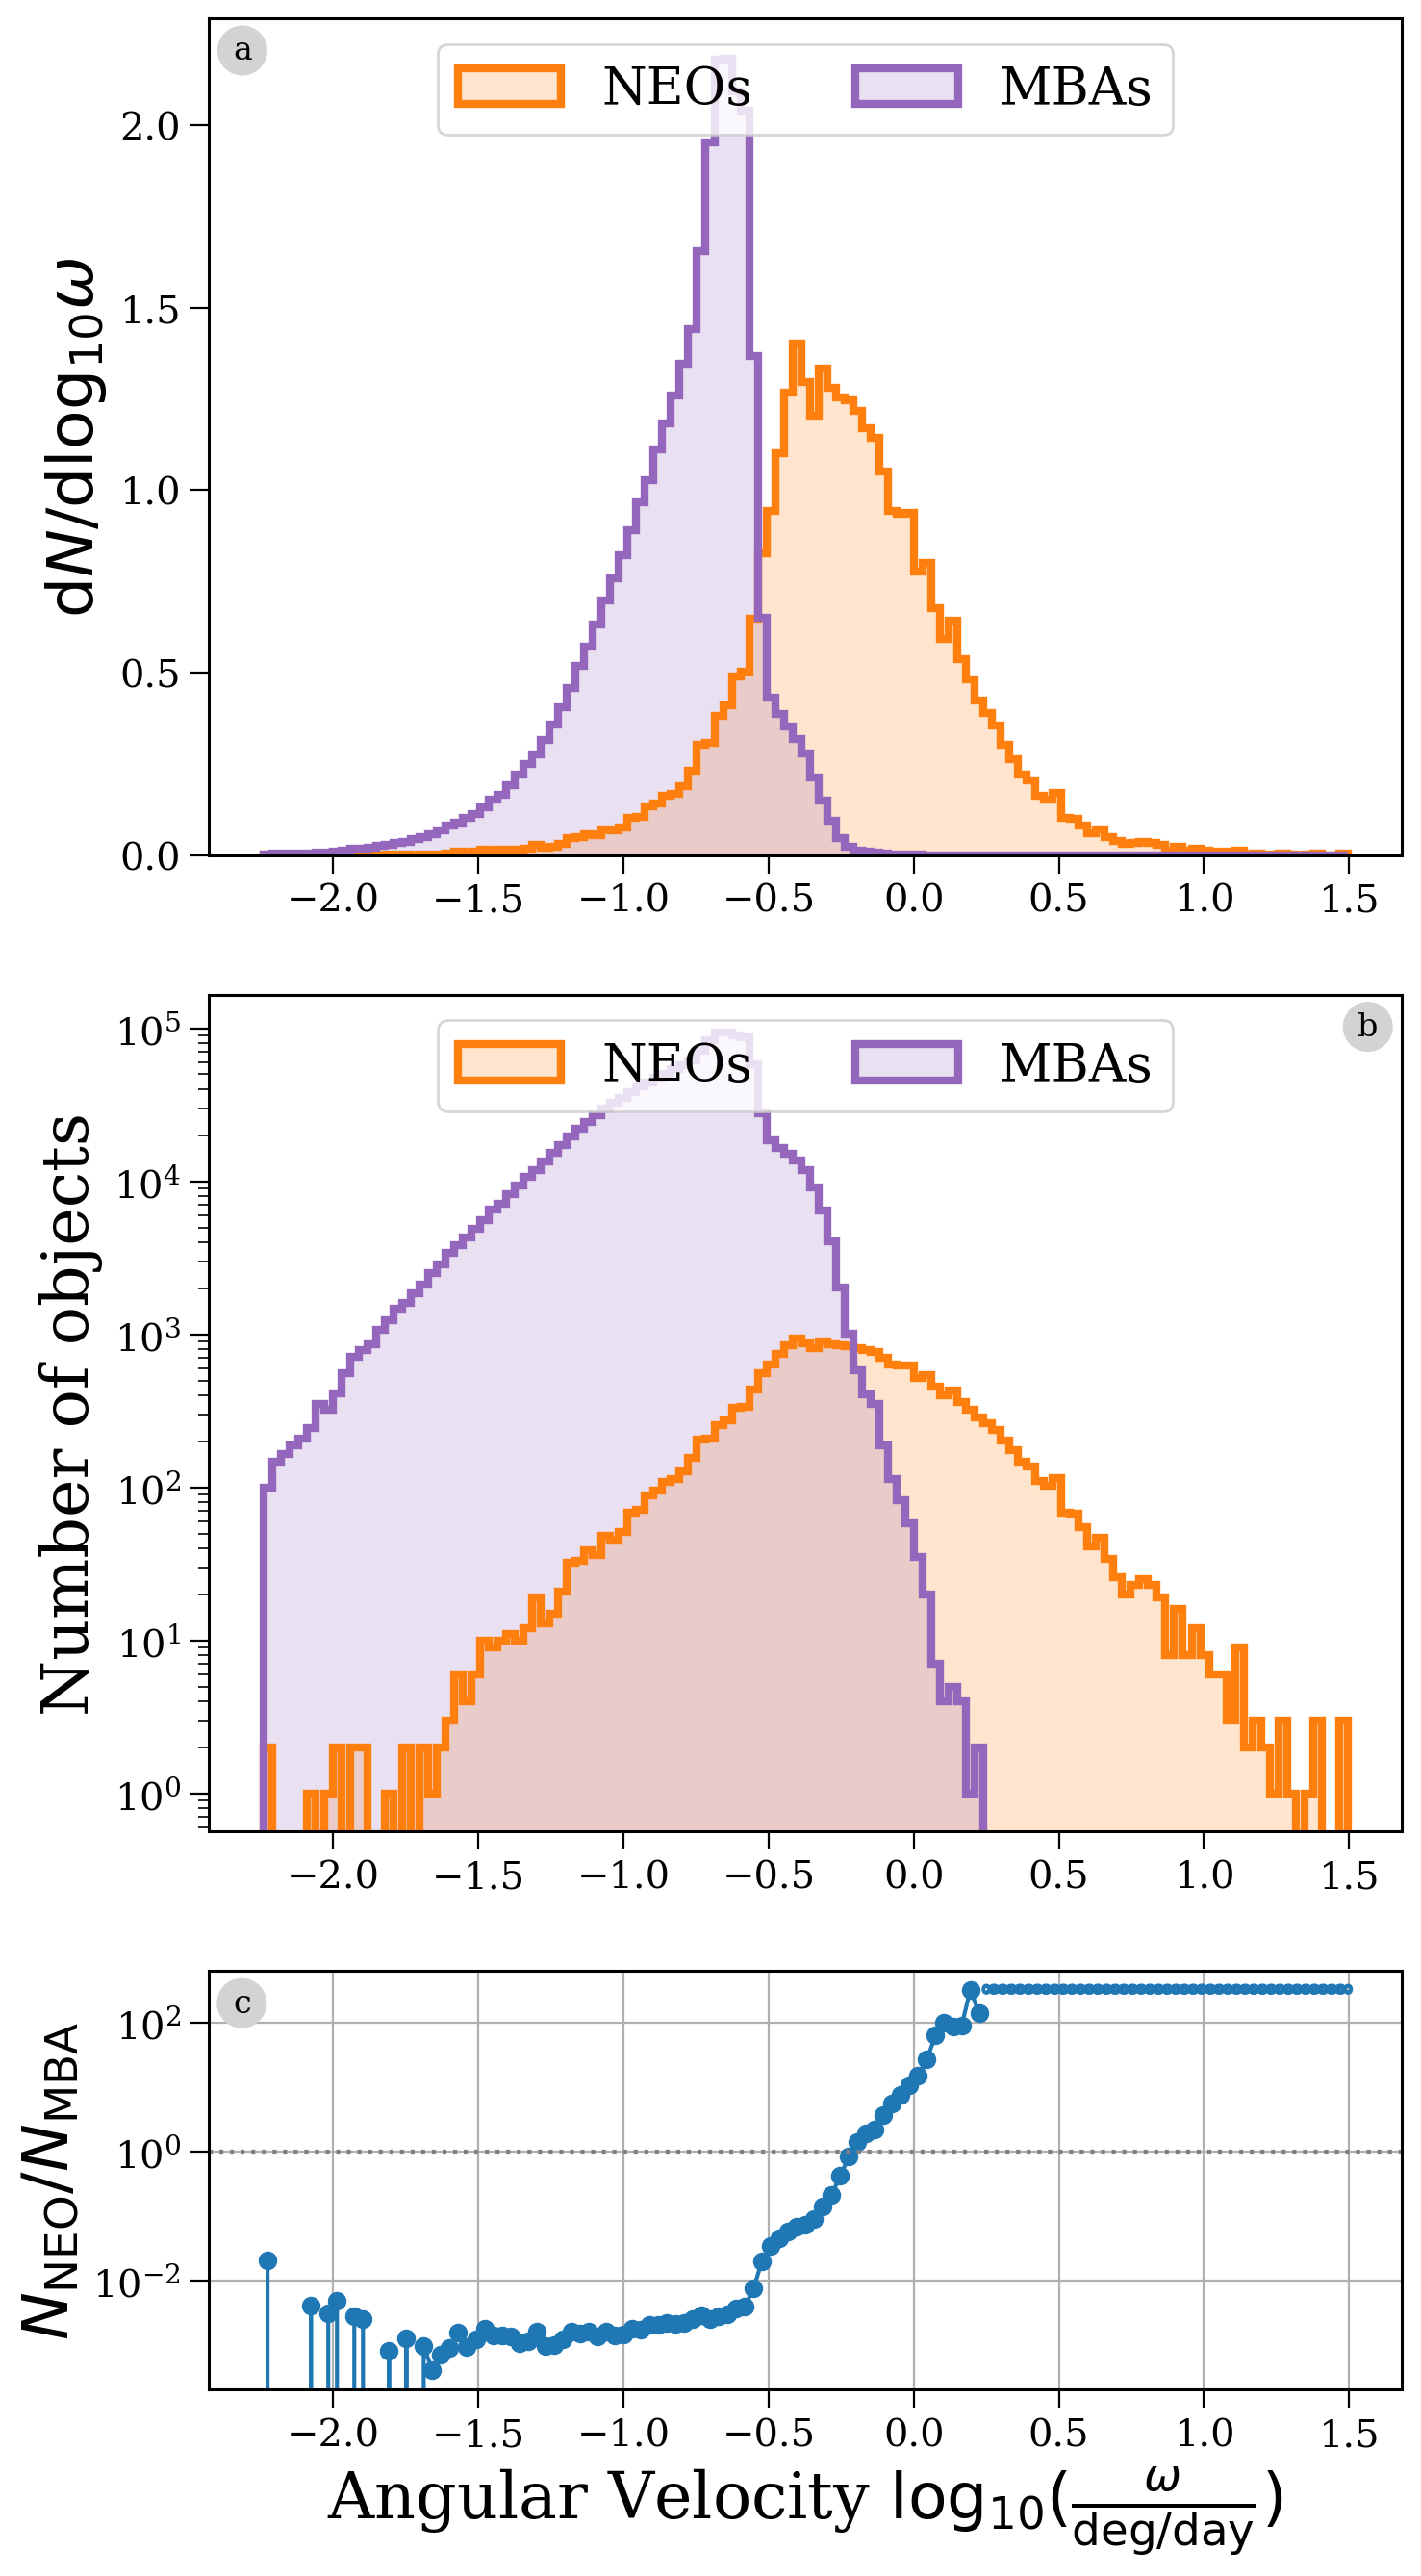

In [78]:
compare_hists("log_ang_vel", r"Angular Velocity $\log_{10}(\frac{\omega}{\rm deg / day})$", r"$\log_{10} \omega$", neo_obs_dd, mba_obs_dd,
              density="both", figsize=(8, 16), apply_score_cut=True)

In [34]:
(1 * u.deg / u.day).to(u.arcsecond / (30 * u.second))

<Quantity 1.25 0.0333333 arcsec / s>

In [235]:
f'{len(neo_obs_dd[neo_obs_dd["scores"] >= 65]) / (len(neo_obs_dd[neo_obs_dd["scores"] >= 65]) + len(mba_obs_dd[mba_obs_dd["scores"] >= 65])) * 100:1.1f}%'

'1.5%'

In [236]:
even_top_score = (len(neo_obs_dd[neo_obs_dd["scores"] == 100])
    / (len(neo_obs_dd[neo_obs_dd["scores"] == 100]) + len(mba_obs_dd[mba_obs_dd["scores"] == 100])) * 100)
f'{even_top_score:1.1f}%'

'10.0%'

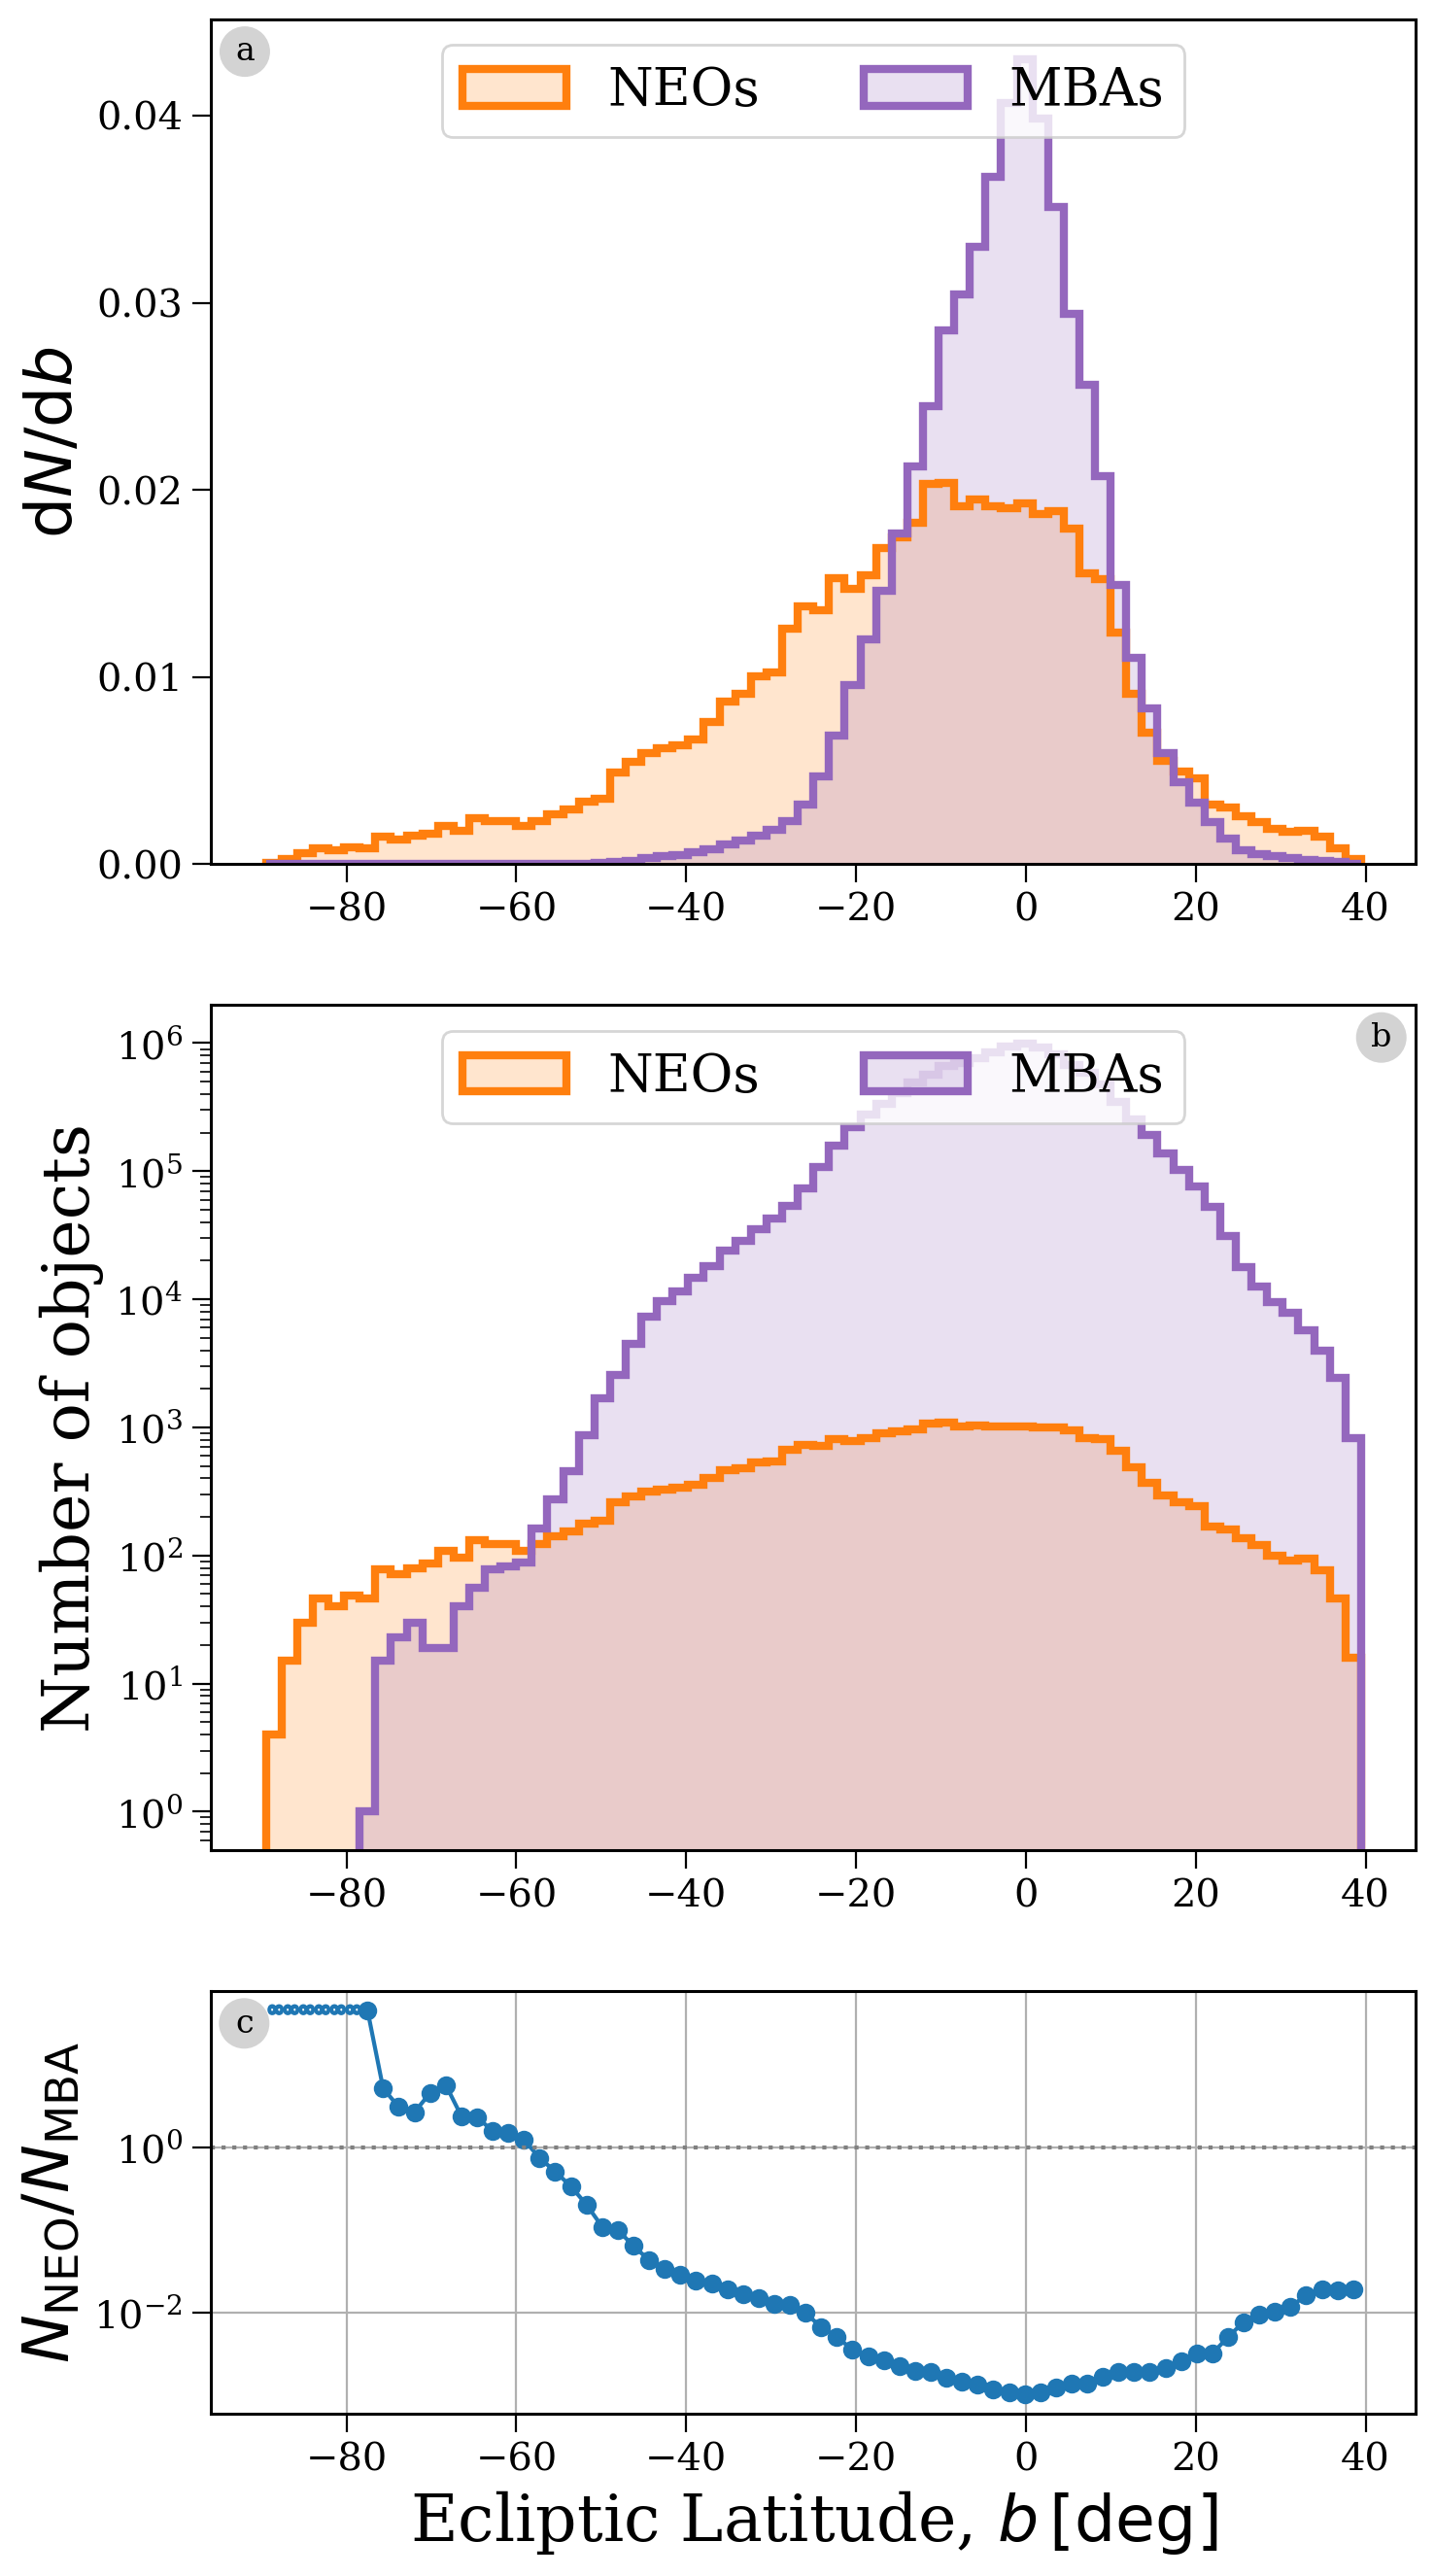

In [386]:
compare_hists("ecl_lat", r"Ecliptic Latitude, $b \, [\rm deg]$", r"$b$",
              neo_obs_dd, mba_obs_dd, save_plot="../paper/figures/ecliptic_latitude_dist_all.pdf")

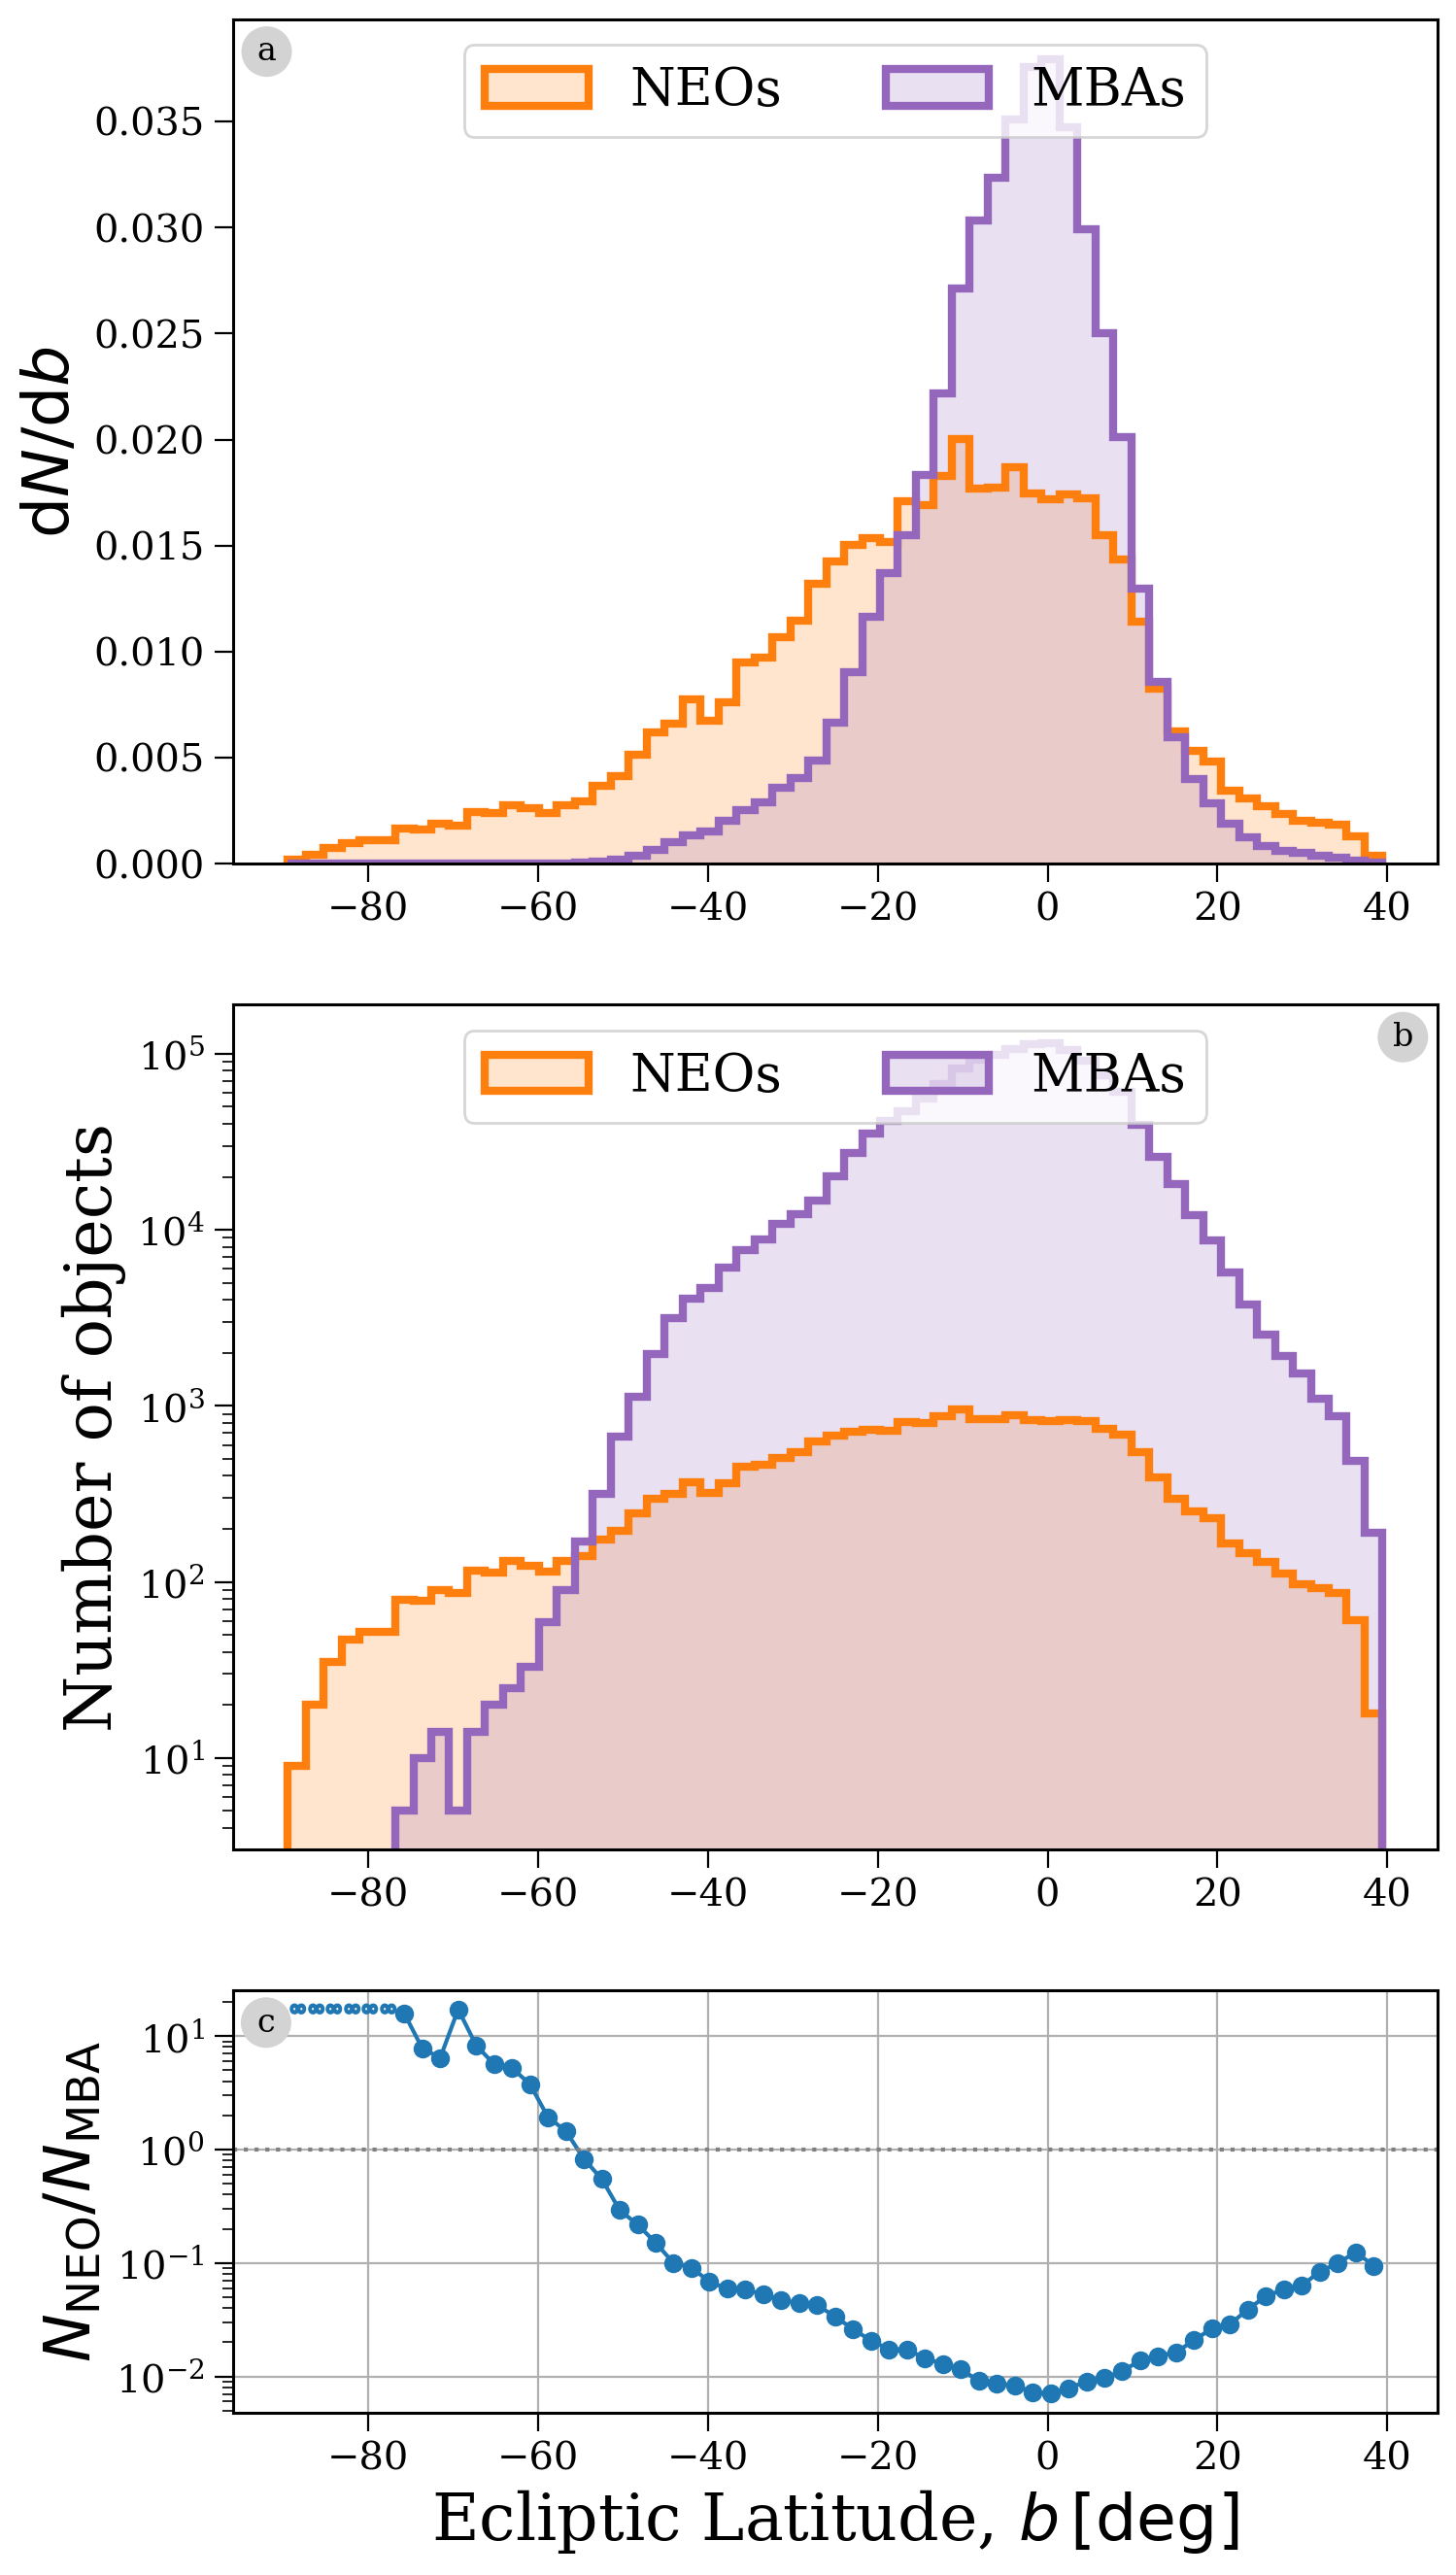

In [387]:
compare_hists("ecl_lat", r"Ecliptic Latitude, $b \, [\rm deg]$", r"$b$",
              neo_obs_dd, mba_obs_dd, apply_score_cut=True,
              save_plot="../paper/figures/ecliptic_latitude_dist_highscore.pdf")

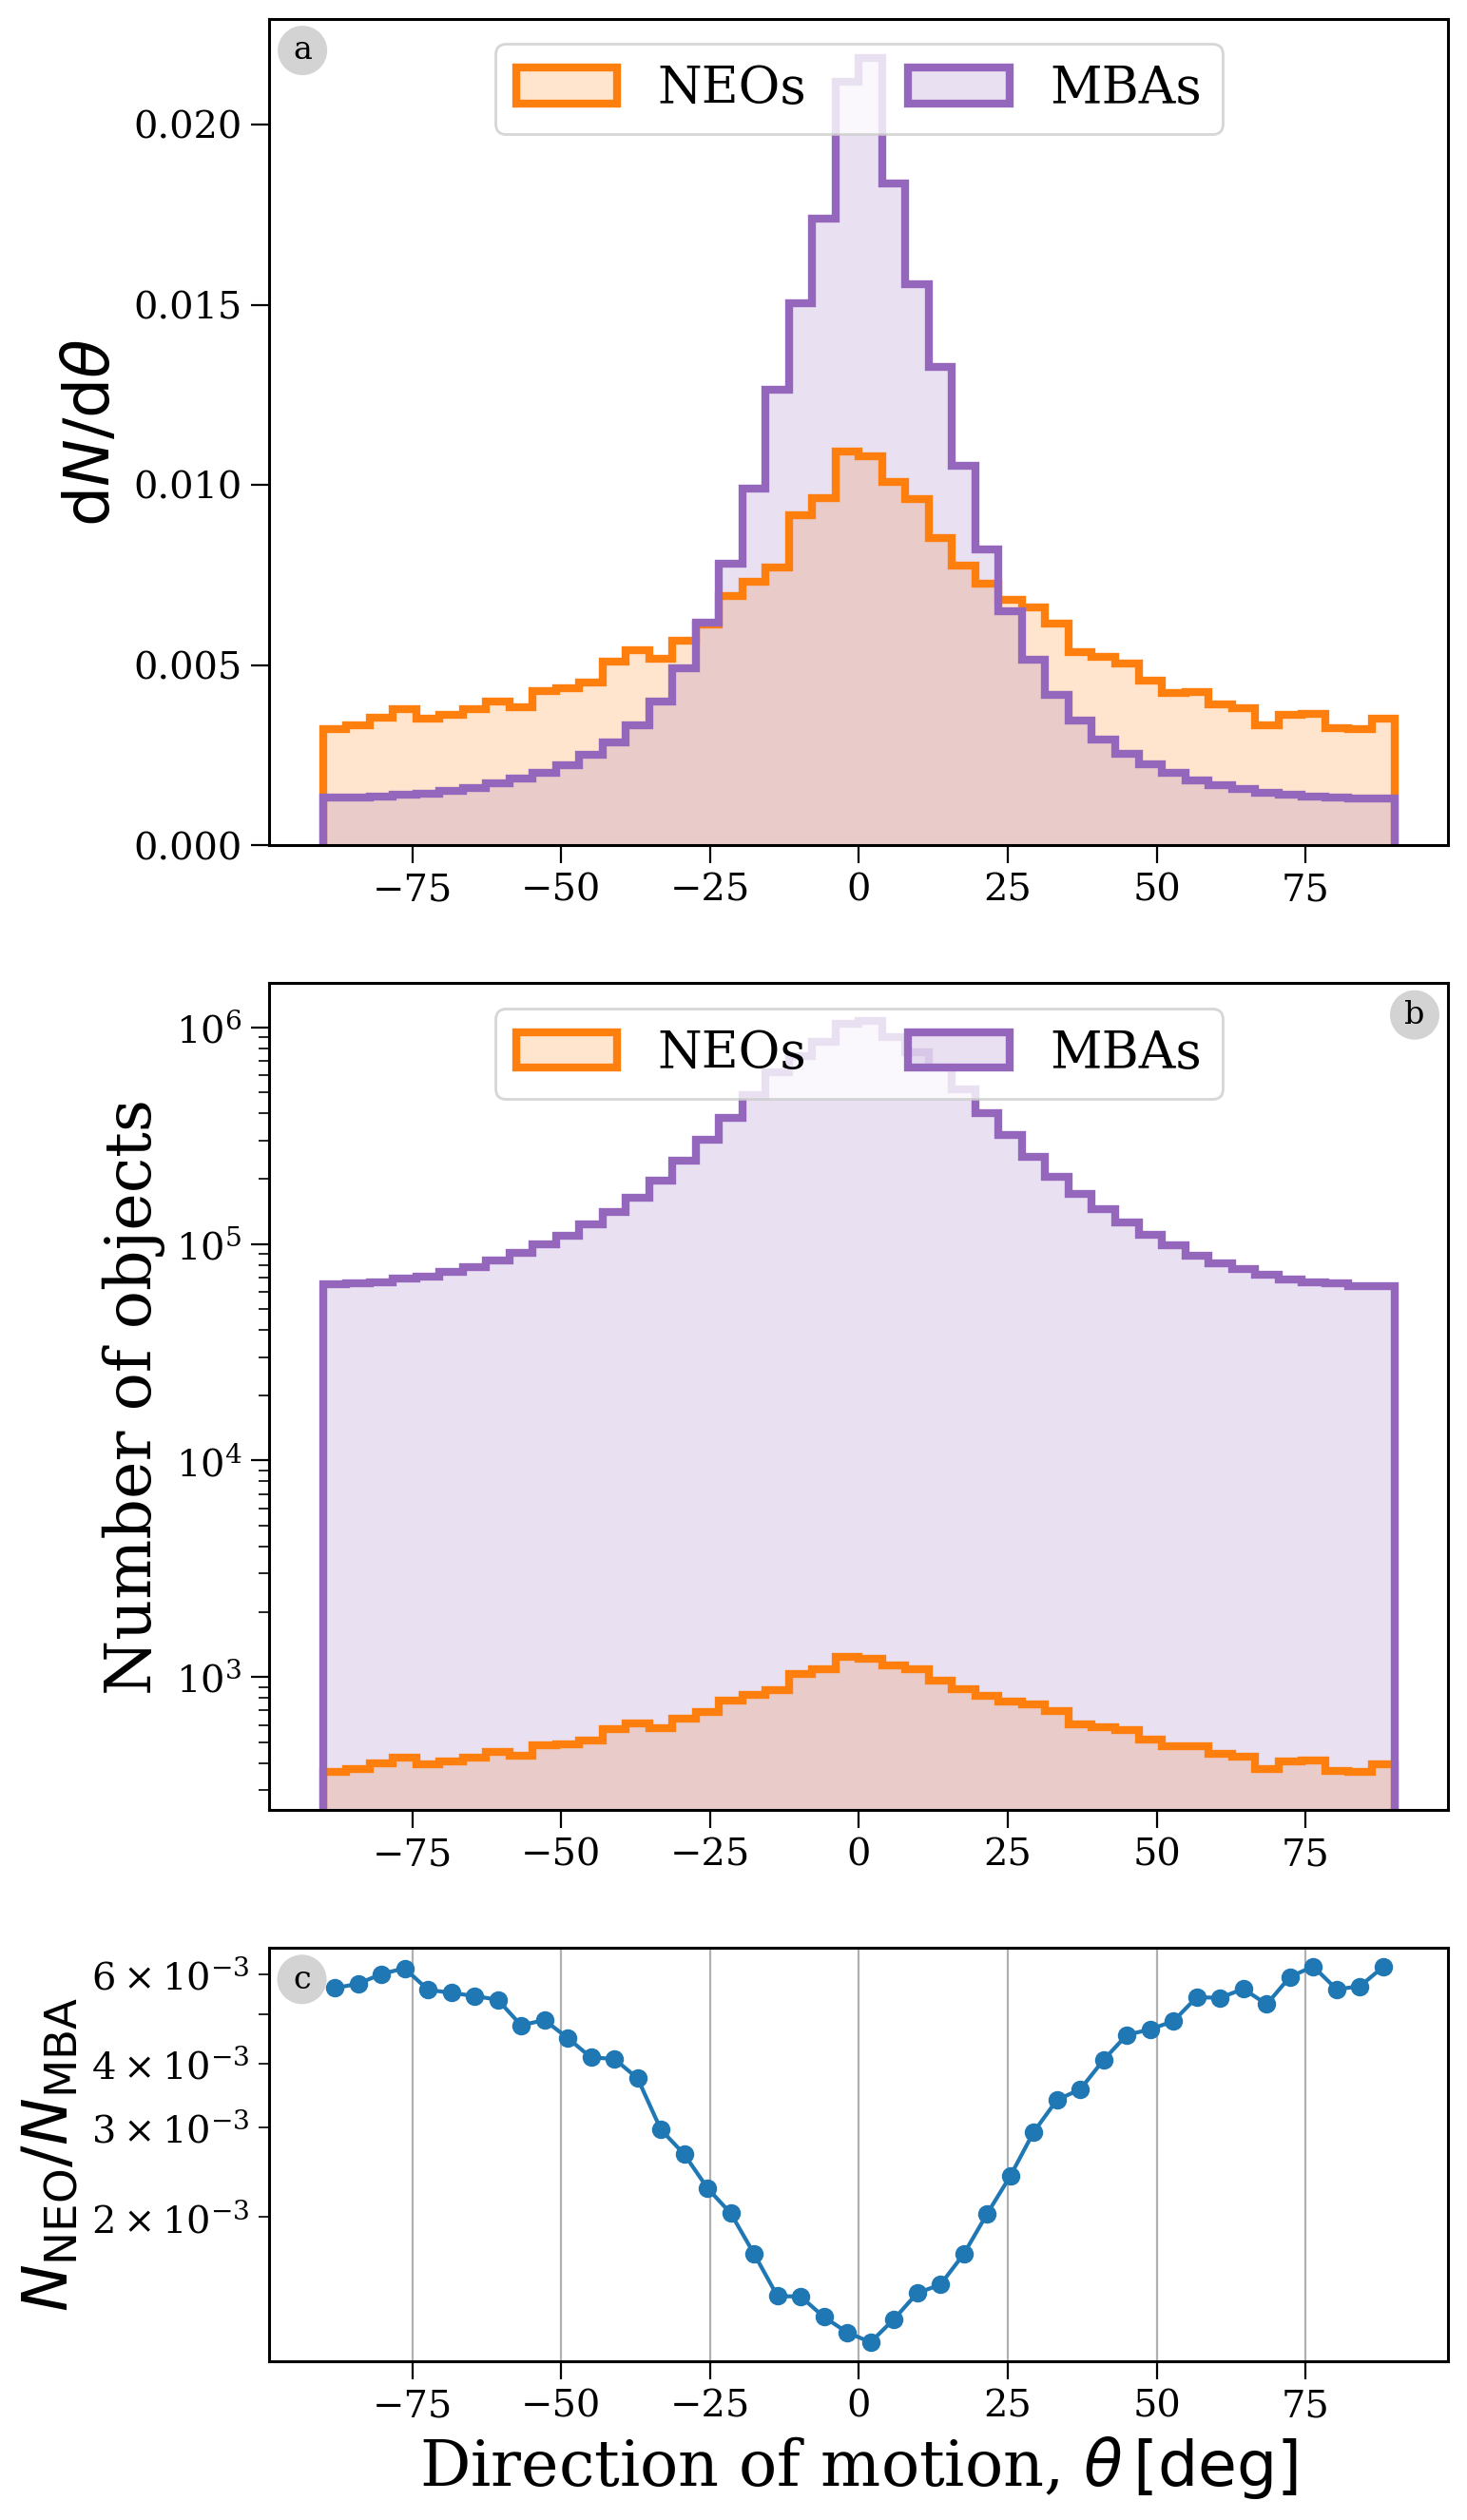

In [388]:
compare_hists("direction", r"Direction of motion, $\theta \, [\rm deg]$", r"$\theta$",
              neo_obs_dd, mba_obs_dd, save_plot="../paper/figures/direction_dist_all.pdf")

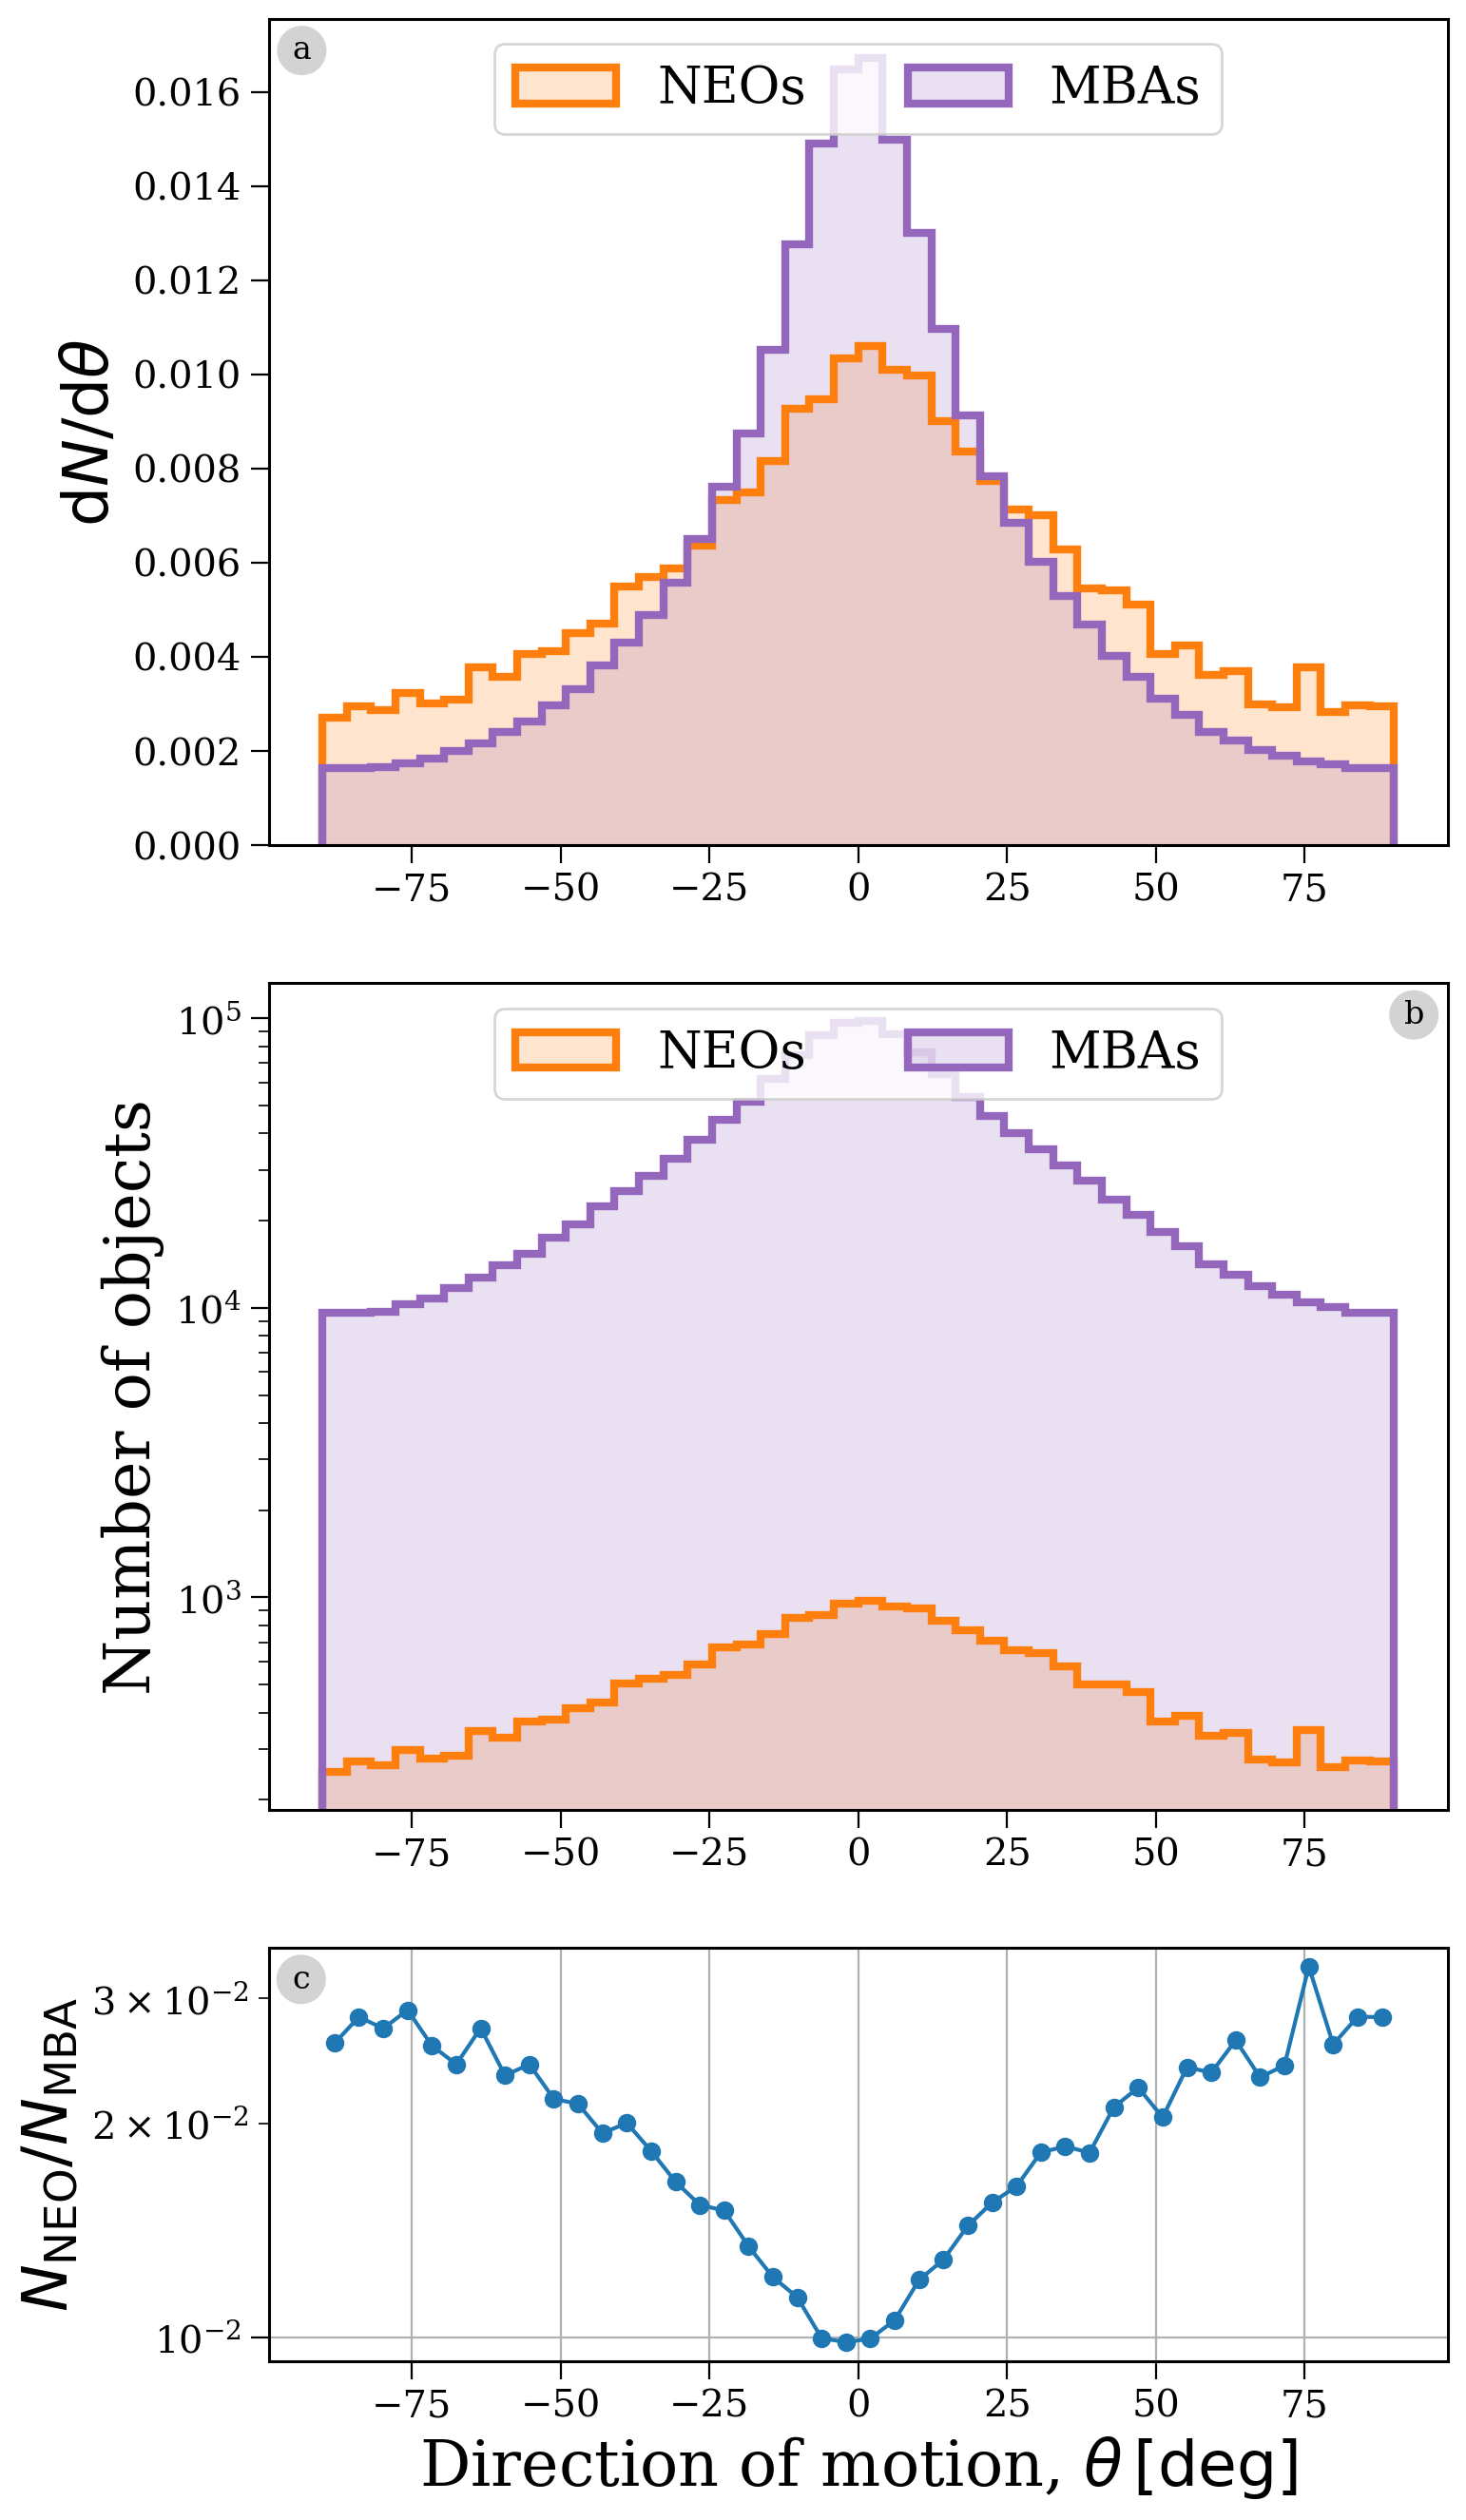

In [389]:
compare_hists("direction", r"Direction of motion, $\theta \, [\rm deg]$", r"$\theta$",
              neo_obs_dd, mba_obs_dd, apply_score_cut=True,
              save_plot="../paper/figures/direction_dist_highscore.pdf")

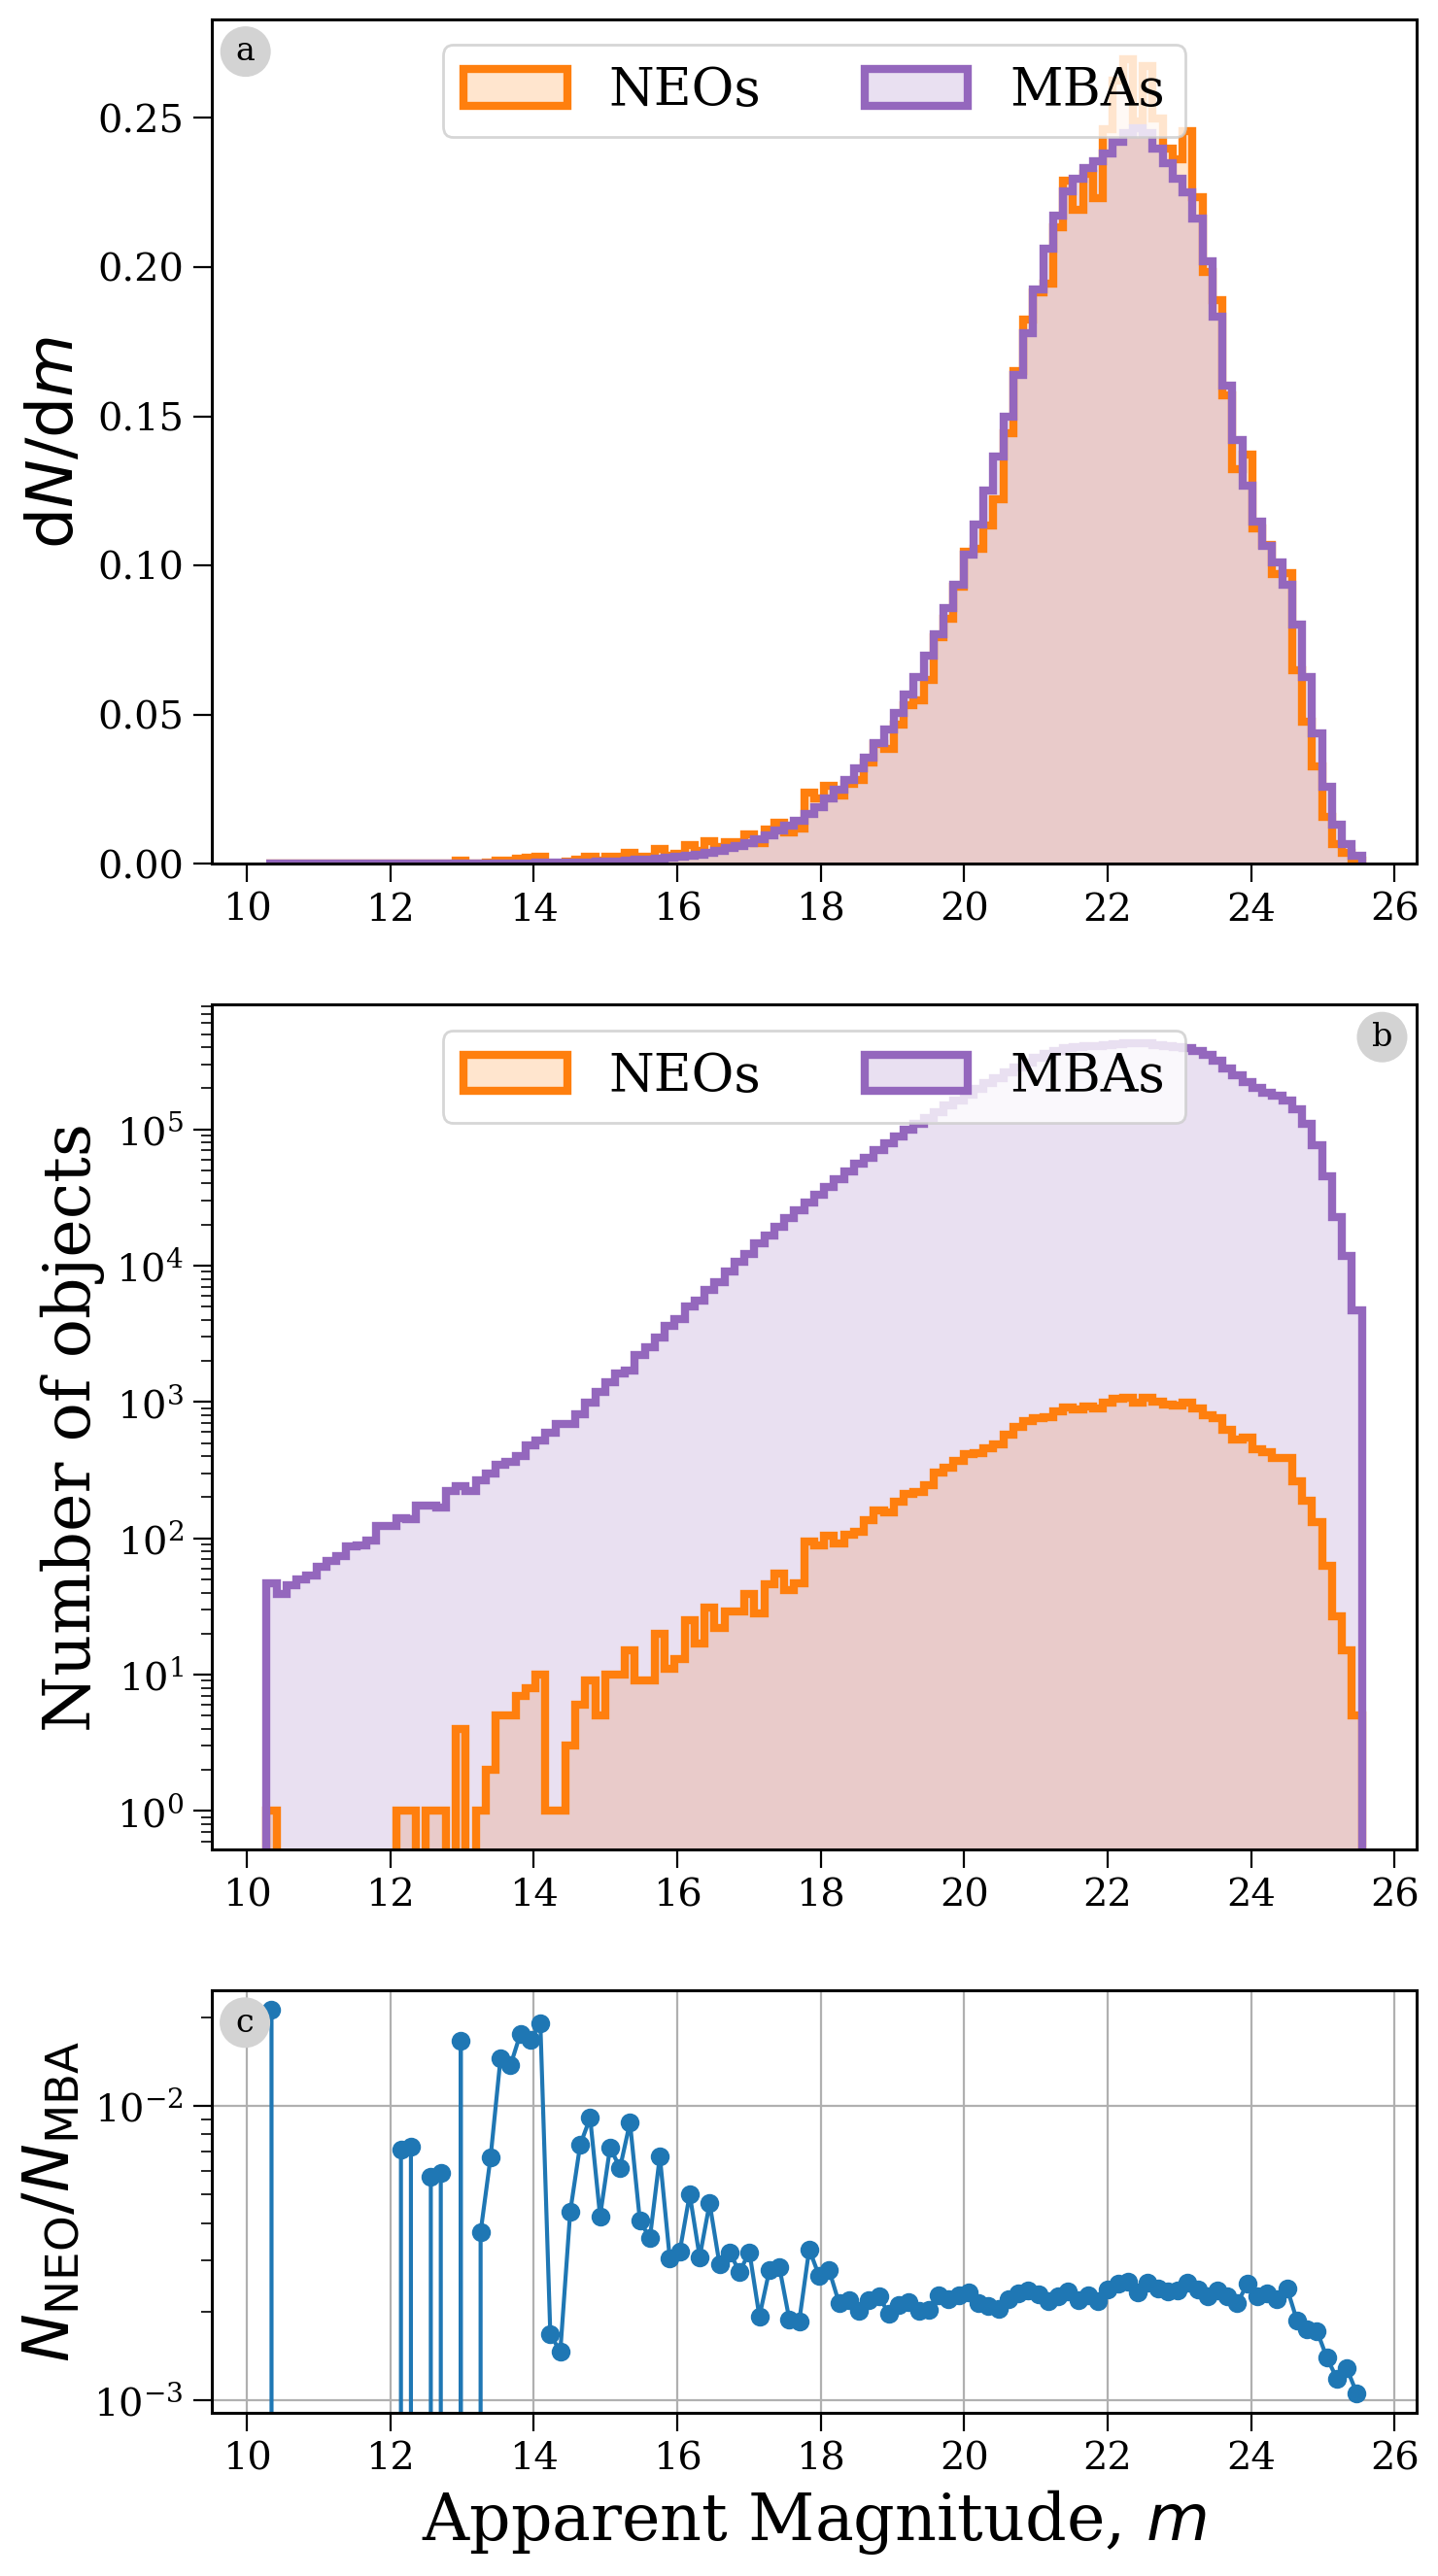

In [390]:
compare_hists("v_mag", r"Apparent Magnitude, $m$", r"$m$",
              neo_obs_dd, mba_obs_dd, save_plot="../paper/figures/apparent_mag_dist_all.pdf")

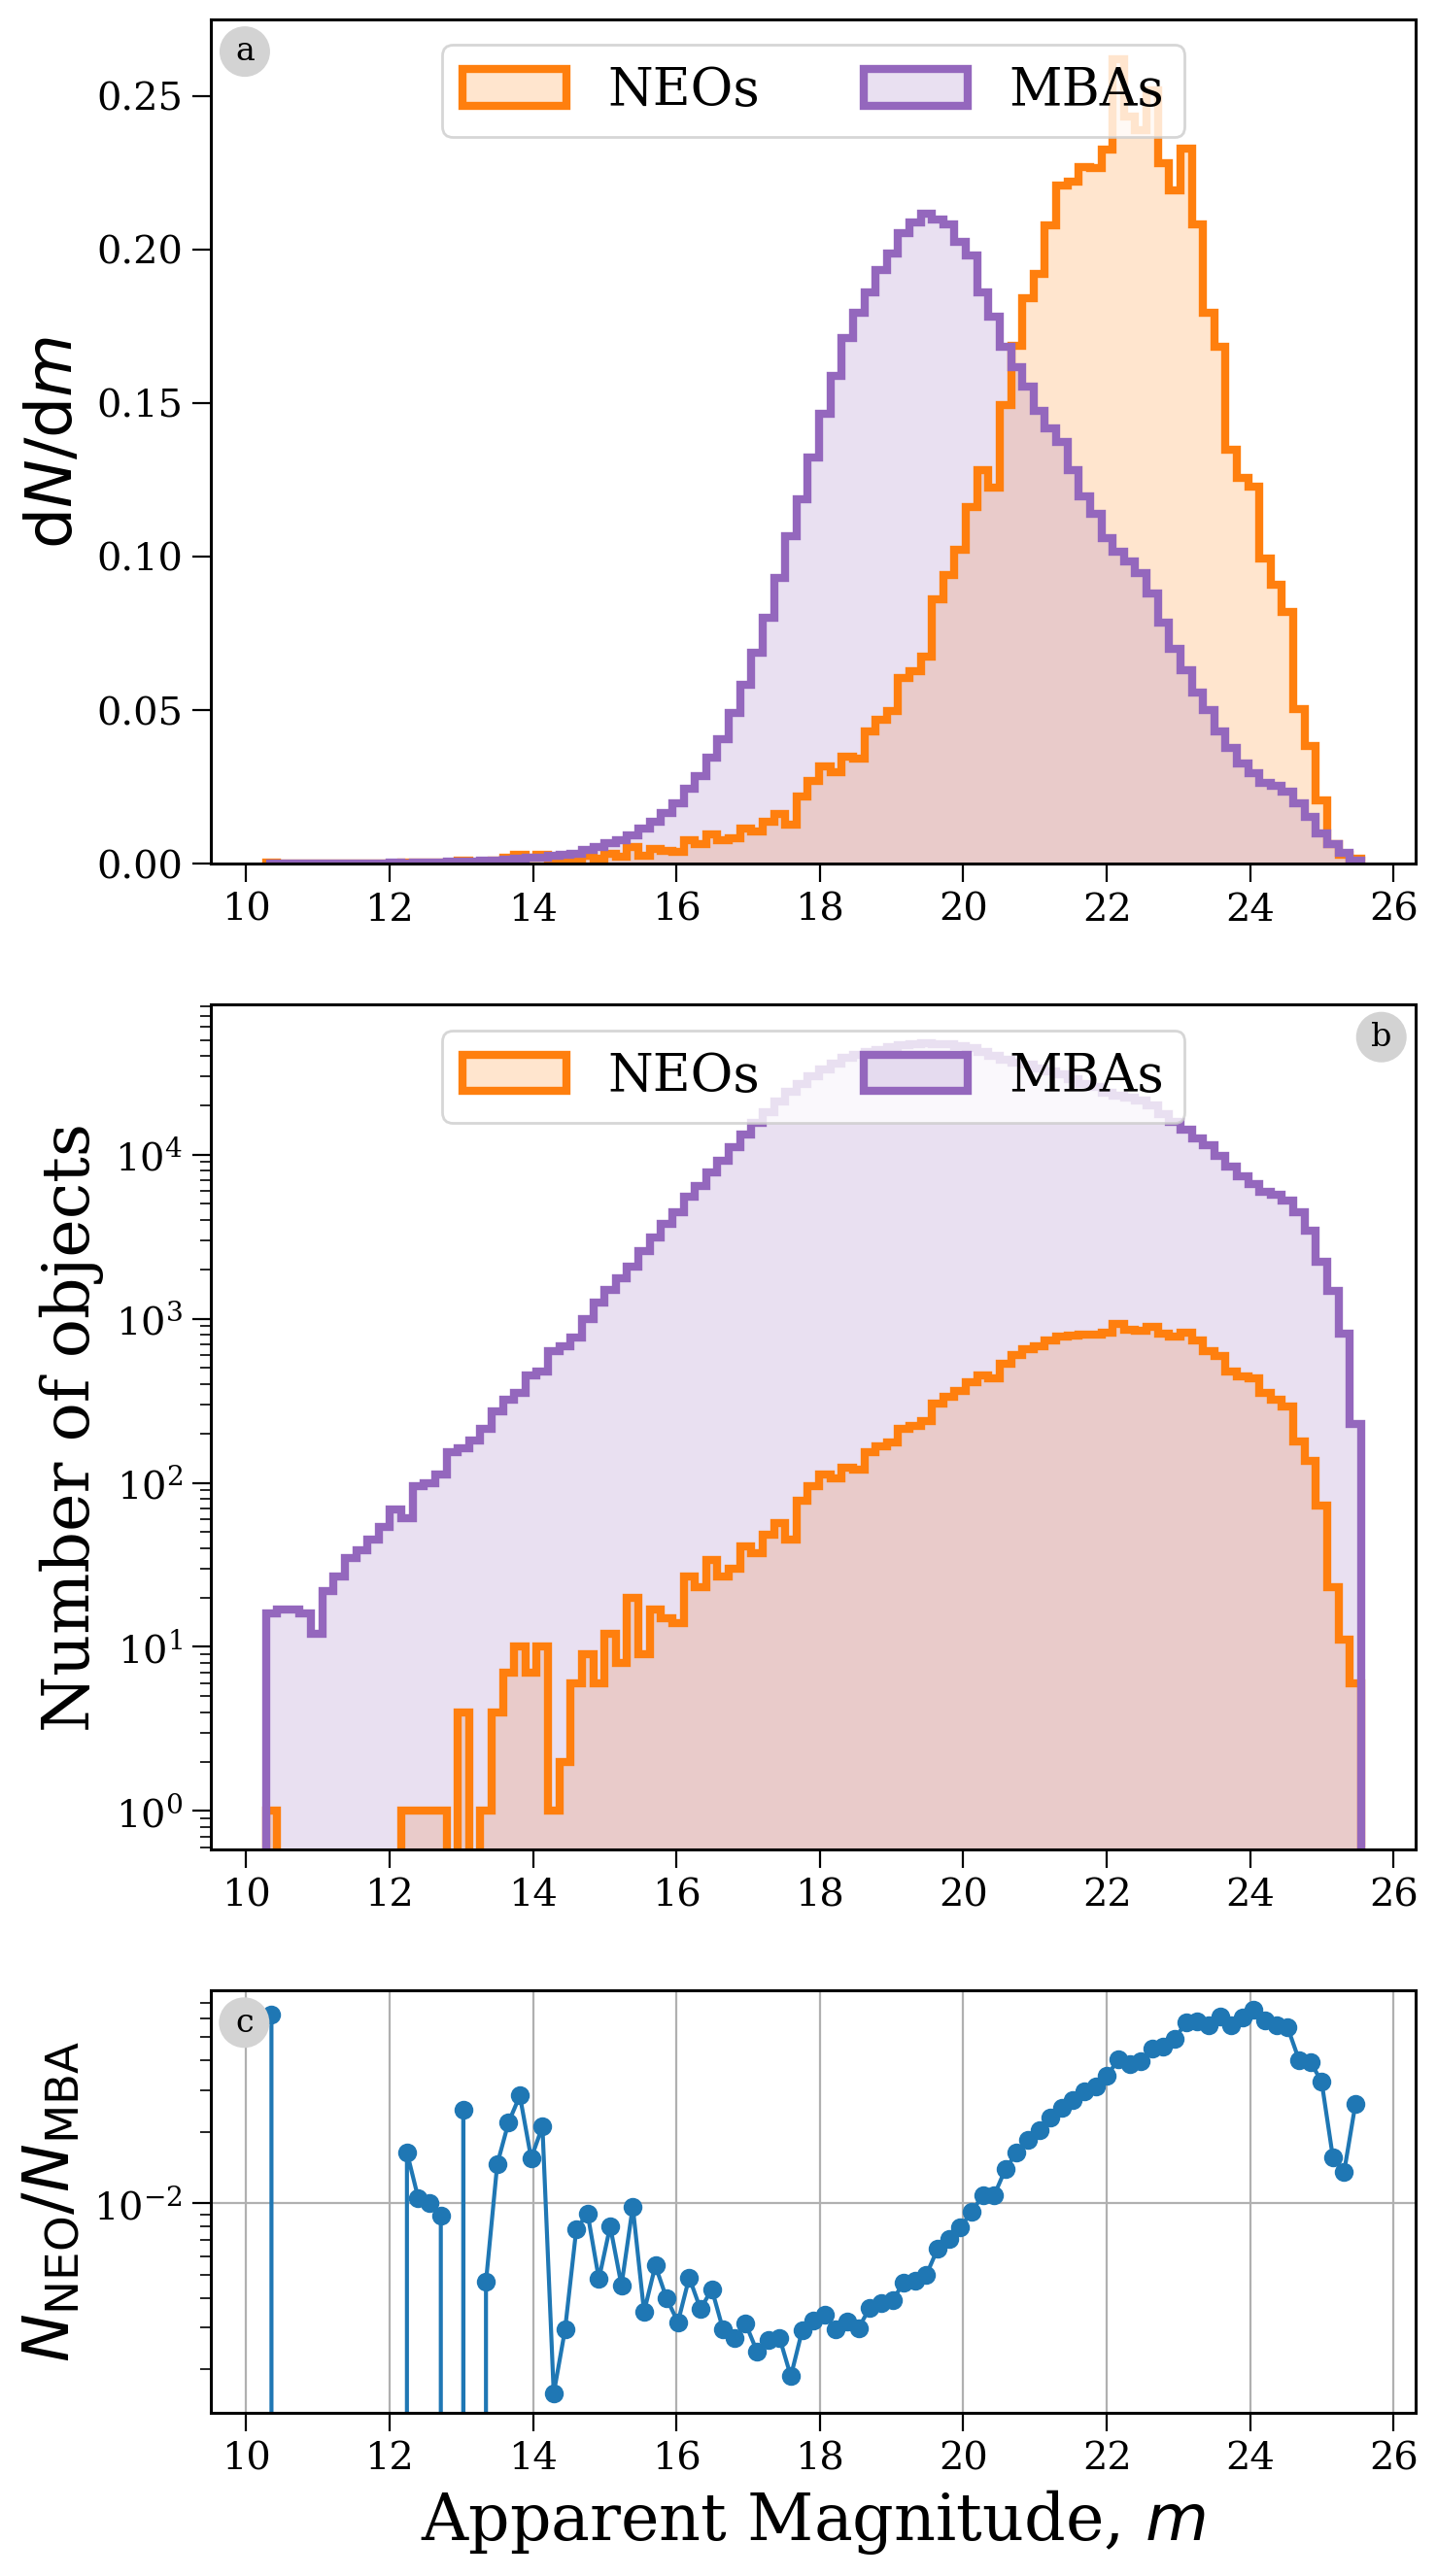

In [391]:
compare_hists("v_mag", r"Apparent Magnitude, $m$", r"$m$",
              neo_obs_dd, mba_obs_dd, apply_score_cut=True,
              save_plot="../paper/figures/apparent_mag_dist_highscore.pdf")

# New Scoring Metric

In [18]:
old_thresh = 65
n_neo = (neo_obs_dd["scores"] >= old_thresh).sum()
n_mba = (mba_obs_dd["scores"] >= old_thresh).sum()
f'Traffic {n_neo + n_mba:1.0f}, Purity {n_neo / (n_neo + n_mba):1.3f}, N NEO {n_neo}'

'Traffic 1456345, Purity 0.015, N NEO 22479'

In [31]:
def new_scoring(df, cols, weights, funcs):
    scores = np.zeros(len(df))
    
    for col, weight, func in zip(cols, weights, funcs):
        scores += func(df[col].values) * weight
    
    scores /= sum(weights)
    
    return scores

In [33]:
new_scoring(neo_obs_dd,
            cols=["ecl_lat", "direction", "v_mag"],
            weights=[1., 1., 1.],
            funcs=[lambda x: np.nan_to_num(x, 0.0),
                   lambda x: np.abs(x) / 0.9,
                   lambda x: np.abs(x) / 0.9,
                   lambda x: (x - x.min()) / (x.max() - x.min()) * 100])

array([ 11.5071613 , -12.8413824 ,   5.90862676, ...,  25.74099243,
        31.0766477 ,  15.42522862])

In [21]:
plt.hist(new_scores[0][neo_obs_dd["scores"].values >= 65], bins='fd', density=True)
plt.hist(new_scores[1][mba_obs_dd["scores"].values >= 65], bins='fd', density=True, alpha=0.5)
plt.show()

NameError: name 'new_scores' is not defined

In [22]:
neo_obs_pass = neo_obs_dd[neo_obs_dd["scores"] >= 65]
mba_obs_pass = mba_obs_dd[mba_obs_dd["scores"] >= 65]

In [46]:
def test_scoring_scheme(a=1, b=1, c=1, thresh=25):
    new_scores = [new_scoring(obs,
                          cols=["ecl_lat", "direction", "v_mag"],
                          weights=[a, b, c],
                          funcs=[lambda x: np.abs(x) / 0.9,
                                 lambda x: np.abs(x) / 0.9,
                                 lambda x: (x - x.min()) / (x.max() - x.min()) * 100])
              for obs in [neo_obs_pass, mba_obs_pass]]

    n_neo = (new_scores[0] >= thresh).sum()
    n_mba = (new_scores[1] >= thresh).sum()
    
    traffic = n_neo + n_mba
    purity = n_neo / traffic
    
    return f'Traffic {traffic:1.0f}, Purity {purity * 100:1.3f}%, N NEO {n_neo}'

In [391]:
thresholds = np.linspace(20, 90, 1000)

new_scores = [new_scoring(obs,
                      cols=["ecl_lat", "direction", "v_mag"],
                      weights=[1, 0, 1],
                      funcs=[lambda x: np.abs(x) / 0.9,
                             lambda x: np.abs(x) / 0.9,
                             lambda x: (x - x.min()) / (x.max() - x.min()) * 100])
          for obs in [neo_obs_pass, mba_obs_pass]]

n_neos = np.array([(new_scores[0] >= thresh).sum() for thresh in thresholds])
n_mbas = np.array([(new_scores[1] >= thresh).sum() for thresh in thresholds])

In [392]:
neo_obs_pass["new_scores"] = new_scores[0]
mba_obs_pass["new_scores"] = new_scores[1]

/tmp/ipykernel_31431/2406790240.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neo_obs_pass["new_scores"] = new_scores[0]
/tmp/ipykernel_31431/2406790240.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mba_obs_pass["new_scores"] = new_scores[1]


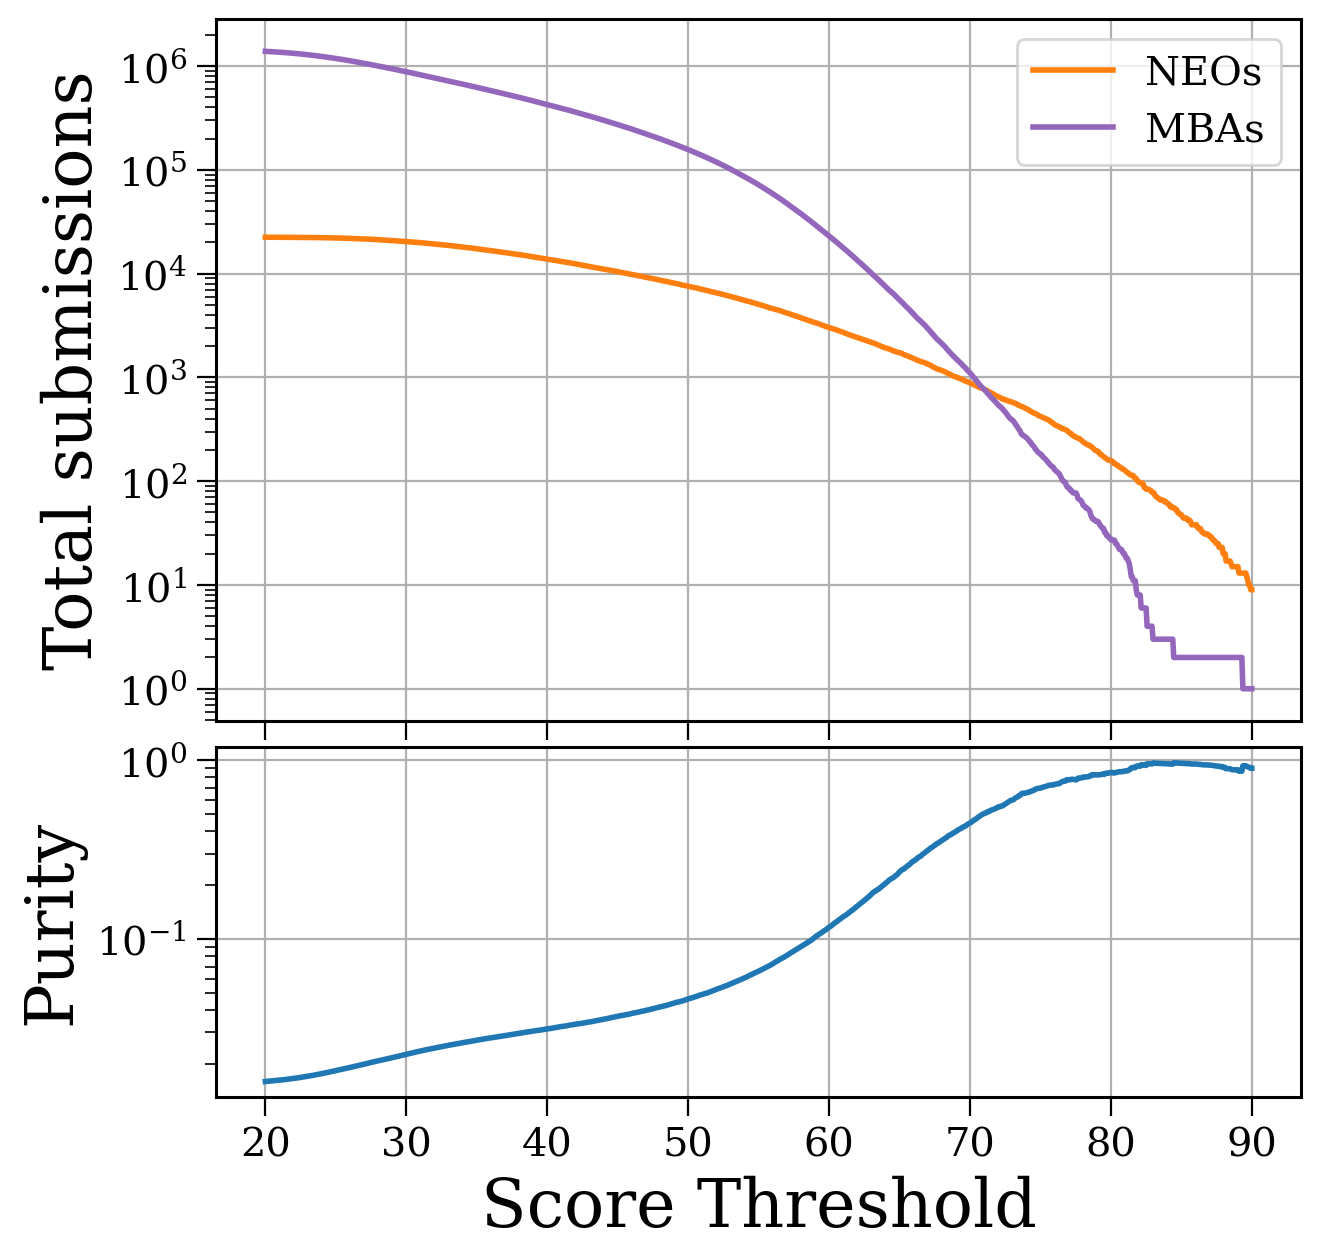

In [381]:
fig, axes = plt.subplots(2, 1, figsize=(7, 7), sharex=True, gridspec_kw={"height_ratios": [2, 1]})
fig.subplots_adjust(hspace=0.05)

axes[0].plot(thresholds, n_neos, color=list(plt.get_cmap("tab10")(1)), lw=2, label="NEOs")
axes[0].plot(thresholds, n_mbas, color=list(plt.get_cmap("tab10")(4)), lw=2, label="MBAs")
axes[0].set_yscale("log")
axes[0].set_ylabel("Total submissions")
axes[0].grid()
axes[0].legend(fontsize=0.6*fs)

axes[1].plot(thresholds, n_neos / (n_neos + n_mbas), lw=2)
axes[1].set_yscale("log")
axes[1].set_ylabel("Purity")
axes[1].set_xlabel("Score Threshold")
axes[1].grid()

plt.savefig("../paper/figures/example_score.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [393]:
len(new_scores[0]) - (new_scores[0] >= 30).sum()

537

In [394]:
len(new_scores[1]) - (new_scores[1] >= 30).sum()

207459

In [395]:
test_scoring_scheme(thresh=25)

'Traffic 1202888, Purity 1.832%, N NEO 22040'

In [133]:
interact(test_scoring_scheme, a=(0, 1, 0.1), b=(0, 1, 0.1), c=(0, 1, 0.1), thresh=(0, 100, 0.5))

interactive(children=(FloatSlider(value=1.0, description='a', max=1.0), FloatSlider(value=1.0, description='b'…

<function __main__.test_scoring_scheme(a=1, b=1, c=1, thresh=25)>

# Sorting for perfect scores

In [396]:
neo_obs_perf = neo_obs_pass[neo_obs_pass["scores"] == 100]
mba_obs_perf = mba_obs_pass[mba_obs_pass["scores"] == 100]

In [397]:
n_nights = len(mba_obs["night"].unique())

In [398]:
perf_neo_nightly = int(np.round(len(neo_obs_perf) / n_nights))
perf_mba_nightly = int(np.round(len(mba_obs_perf) / n_nights))

perf_neo_nightly, perf_mba_nightly

(52, 468)

In [399]:
def sample_effect_of_sorting(n_follow_possible=100, n_samples=10):
    
    score_order_neos = np.zeros(n_samples)
    random_order_neos = np.zeros(n_samples)
    
    for i in range(n_samples):
        night_neo_scores = neo_obs_perf.sample(perf_neo_nightly)["new_scores"].values
        night_mba_scores = mba_obs_perf.sample(perf_mba_nightly)["new_scores"].values

        is_neo = np.repeat(True, perf_neo_nightly + perf_mba_nightly)
        is_neo[perf_neo_nightly:] = False

        random_order = np.random.choice(len(is_neo), size=len(is_neo))
        score_order = np.argsort(-np.concatenate((night_neo_scores, night_mba_scores)))
        
        score_order_neos[i] = is_neo[score_order][:n_follow_possible].sum()
        random_order_neos[i] = is_neo[random_order][:n_follow_possible].sum()
    
    return score_order_neos, random_order_neos

In [400]:
%%time
son_40, ron_40 = sample_effect_of_sorting(n_follow_possible=40, n_samples=10000)
son_100, ron_100 = sample_effect_of_sorting(n_follow_possible=100, n_samples=10000)
son_200, ron_200 = sample_effect_of_sorting(n_follow_possible=200, n_samples=10000)

CPU times: user 2min 43s, sys: 5.42 s, total: 2min 48s
Wall time: 2min 48s


In [401]:
def make_bins(a):
    bins = np.concatenate((np.unique(a) - 0.5, [np.max(a) + 0.5]))
    bin_centres = 0.5 * (bins[1:] + bins[:-1])
    return bins, bin_centres

In [322]:
from scipy.stats import poisson, norm
from scipy.optimize import curve_fit

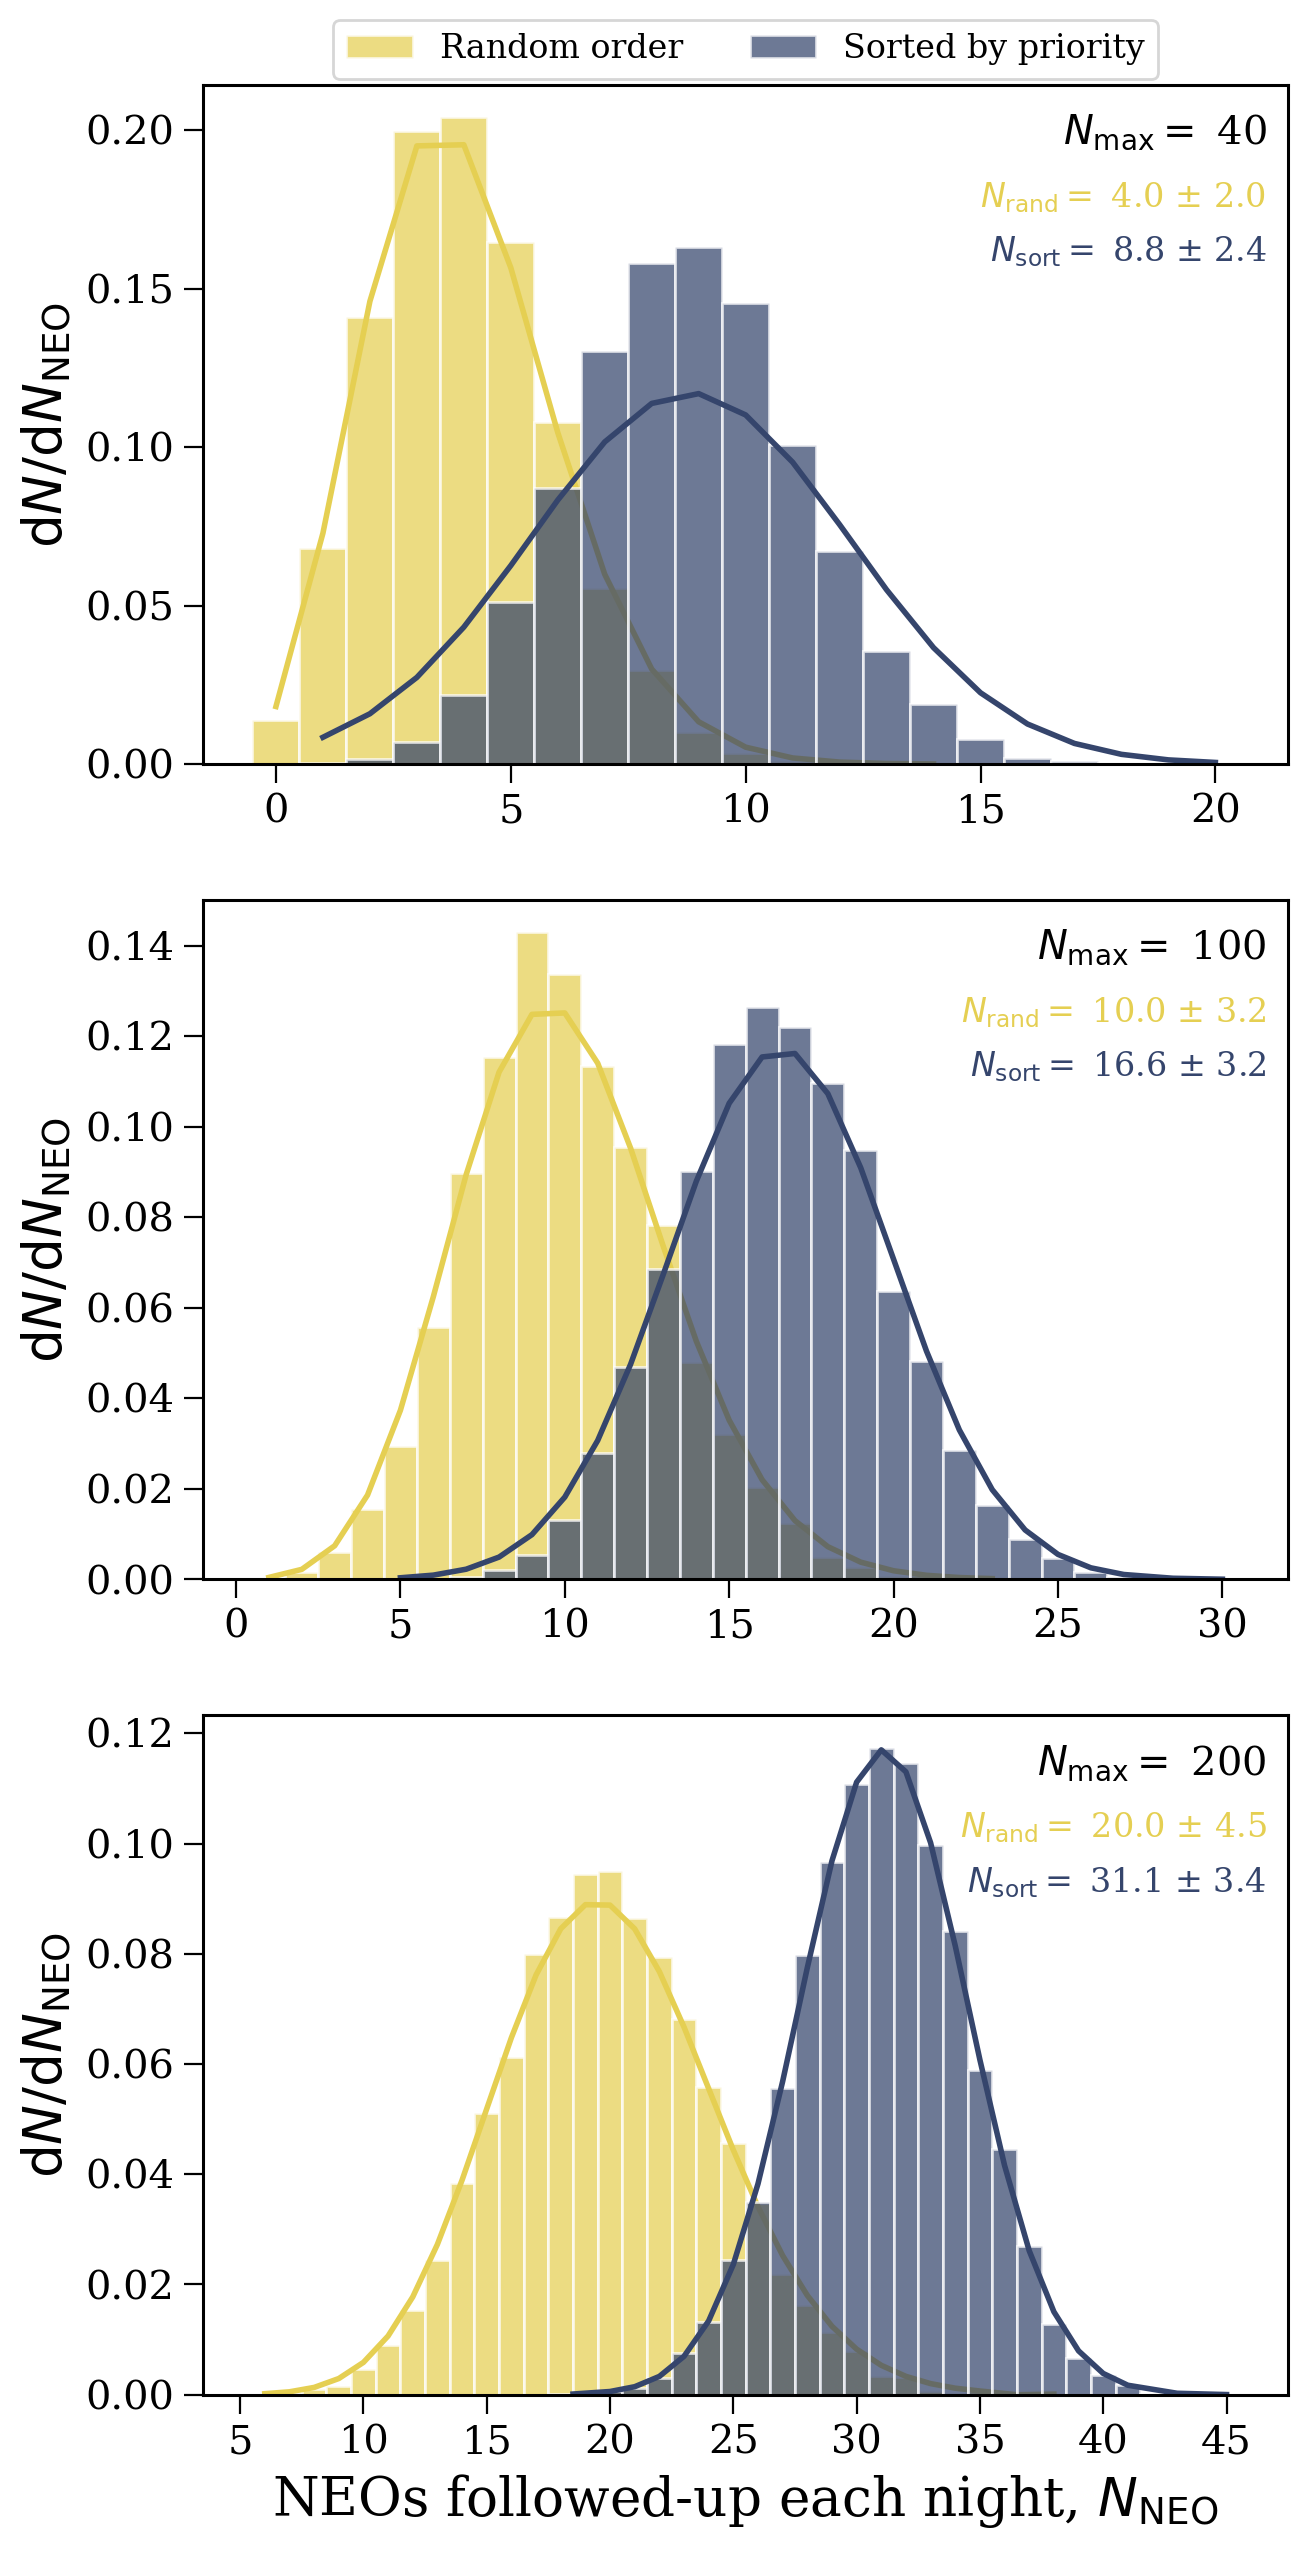

In [405]:
fig, axes = plt.subplots(3, 1, figsize=(7, 15))

for ax, son, ron, nmax in zip(axes, 
                              [son_40, son_100, son_200],
                              [ron_40, ron_100, ron_200],
                              [40, 100, 200]):
    for dist, col, label, alpha in zip([ron, son],
                                       [plt.get_cmap("cividis")(0.9), plt.get_cmap("cividis")(0.2)],
                                       ["Random order", "Sorted by priority"],
                                       [0.8, 0.8]):
        bins, bin_centres = make_bins(dist)
        h = ax.hist(dist, bins=bins, density=True,
                    color=col, label=label, alpha=alpha * 0.9, zorder=2, edgecolor="white")[0]
        
        if np.all(dist == ron):
            ax.plot(bin_centres, poisson(np.mean(dist)).pmf(bin_centres), color=col, zorder=2, lw=2)
            sig = np.sqrt(np.mean(dist))
            ax.annotate(r"$N_{\rm rand} = $ " + f"{np.mean(dist):1.1f}" + r" $\pm$ " + f"{sig:1.1f}", xy=(0.98, 0.86),
                        xycoords="axes fraction", ha="right", va="top", fontsize=0.5*fs, color=col)
        else:
            sig = curve_fit(lambda x, sig: norm(np.mean(dist), sig).pdf(x), bin_centres, h)[0][0]
            ax.plot(bin_centres, norm(np.mean(dist), popt[0]).pdf(bin_centres), color=col, zorder=2, lw=2)
            ax.annotate(r"$N_{\rm sort} = $ " + f"{np.mean(dist):1.1f}" + r" $\pm$ " + f"{sig:1.1f}", xy=(0.98, 0.78),
                        xycoords="axes fraction", ha="right", va="top", fontsize=0.5*fs, color=col) 
    ax.set_ylabel(r"$\mathrm{d}N/\mathrm{d}N_{\rm NEO}$", fontsize=0.8*fs)
    
    ax.annotate(r"$N_{\rm max} = $ " + str(nmax), xy=(0.98, 0.96), xycoords="axes fraction", ha="right", va="top", fontsize=0.6*fs)

axes[-1].set_xlabel(r"NEOs followed-up each night, $N_{\rm NEO}$", fontsize=0.8*fs)
axes[0].legend(fontsize=0.5*fs, loc="upper center", bbox_to_anchor=(0, 1.12, 1, 0), ncol=2)

plt.savefig("../paper/figures/sorting_benefits.pdf", format="pdf", bbox_inches="tight")

plt.show()

# Remove fast movers

In [14]:
%%time
obs_dfs = [pd.read_hdf(f"../current_criteria/neo/filtered_visit_scores_{i:03d}.h5")
            for i in range(24)]
all_neo_obs = pd.concat(obs_dfs)
all_neo_obs = all_neo_obs[all_neo_obs["n_obs"] >= 2]

CPU times: user 637 ms, sys: 80.2 ms, total: 718 ms
Wall time: 715 ms


In [118]:
%%time
all_neo_speeds = all_neo_obs.groupby(by=["ObjID", "night"]).apply(tracklet_speed)

CPU times: user 5min 6s, sys: 6.28 s, total: 5min 12s
Wall time: 5min 11s


In [120]:
all_neo_speeds_flat = all_neo_speeds.reset_index().sort_values(by=["night", "ObjID"])[0].values

In [15]:
all_neo_obs_dd = all_neo_obs.drop_duplicates(subset=["ObjID", "night"]).sort_values(by=["night", "ObjID"])

In [137]:
too_fast = all_neo_obs_dd[all_neo_speeds_flat > 1.5][["ObjID", "night"]]

In [148]:
too_fast.to_hdf("neo_streakers.h5", key='df')

In [152]:
x = len(neo_obs_dd[(neo_obs_dd["scores"] >= 65) & (neo_obs_dd["ang_vel"] < 1.5)])
y = len(mba_obs_dd[(mba_obs_dd["scores"] >= 65) & (mba_obs_dd["ang_vel"] < 1.5)])
f'{x / (x + y) * 100:1.1f}%'

'1.4%'

In [153]:
a = len(neo_obs_dd[(neo_obs_dd["scores"] == 100) & (neo_obs_dd["ang_vel"] < 1.5)])
b = len(mba_obs_dd[(mba_obs_dd["scores"] == 100) & (mba_obs_dd["ang_vel"] < 1.5)])
f'{a / (a + b) * 100:1.1f}%'

'8.6%'

In [6]:
trailed_neos = pd.read_hdf("neo_streakers.h5")

In [13]:
trailed_neos

,ObjID,night
hex_id,,
000095E,S00000DIa,0
0000AE9,S00000Kea,0
000050F,S00000lqa,0
0000686,S00000rHa,0
0001796,S00001C5a,0
...,...,...
003E141,S00015ZTa,377
003ED89,S00016PKa,377
0040F1A,S000198ha,377


In [17]:
s3m = pd.read_hdf("../../hybrid-sso-catalogs/catalogues/s3m_initial.h5")

In [20]:
trailed_params = s3m.loc[trailed_neos["ObjID"].values]

In [27]:
mask = np.isin(all_neo_obs_dd["ObjID"].values, trailed_neos["ObjID"].values)

In [28]:
all_neo_H = s3m.loc[all_neo_obs_dd["ObjID"].values[~mask]]["H"]

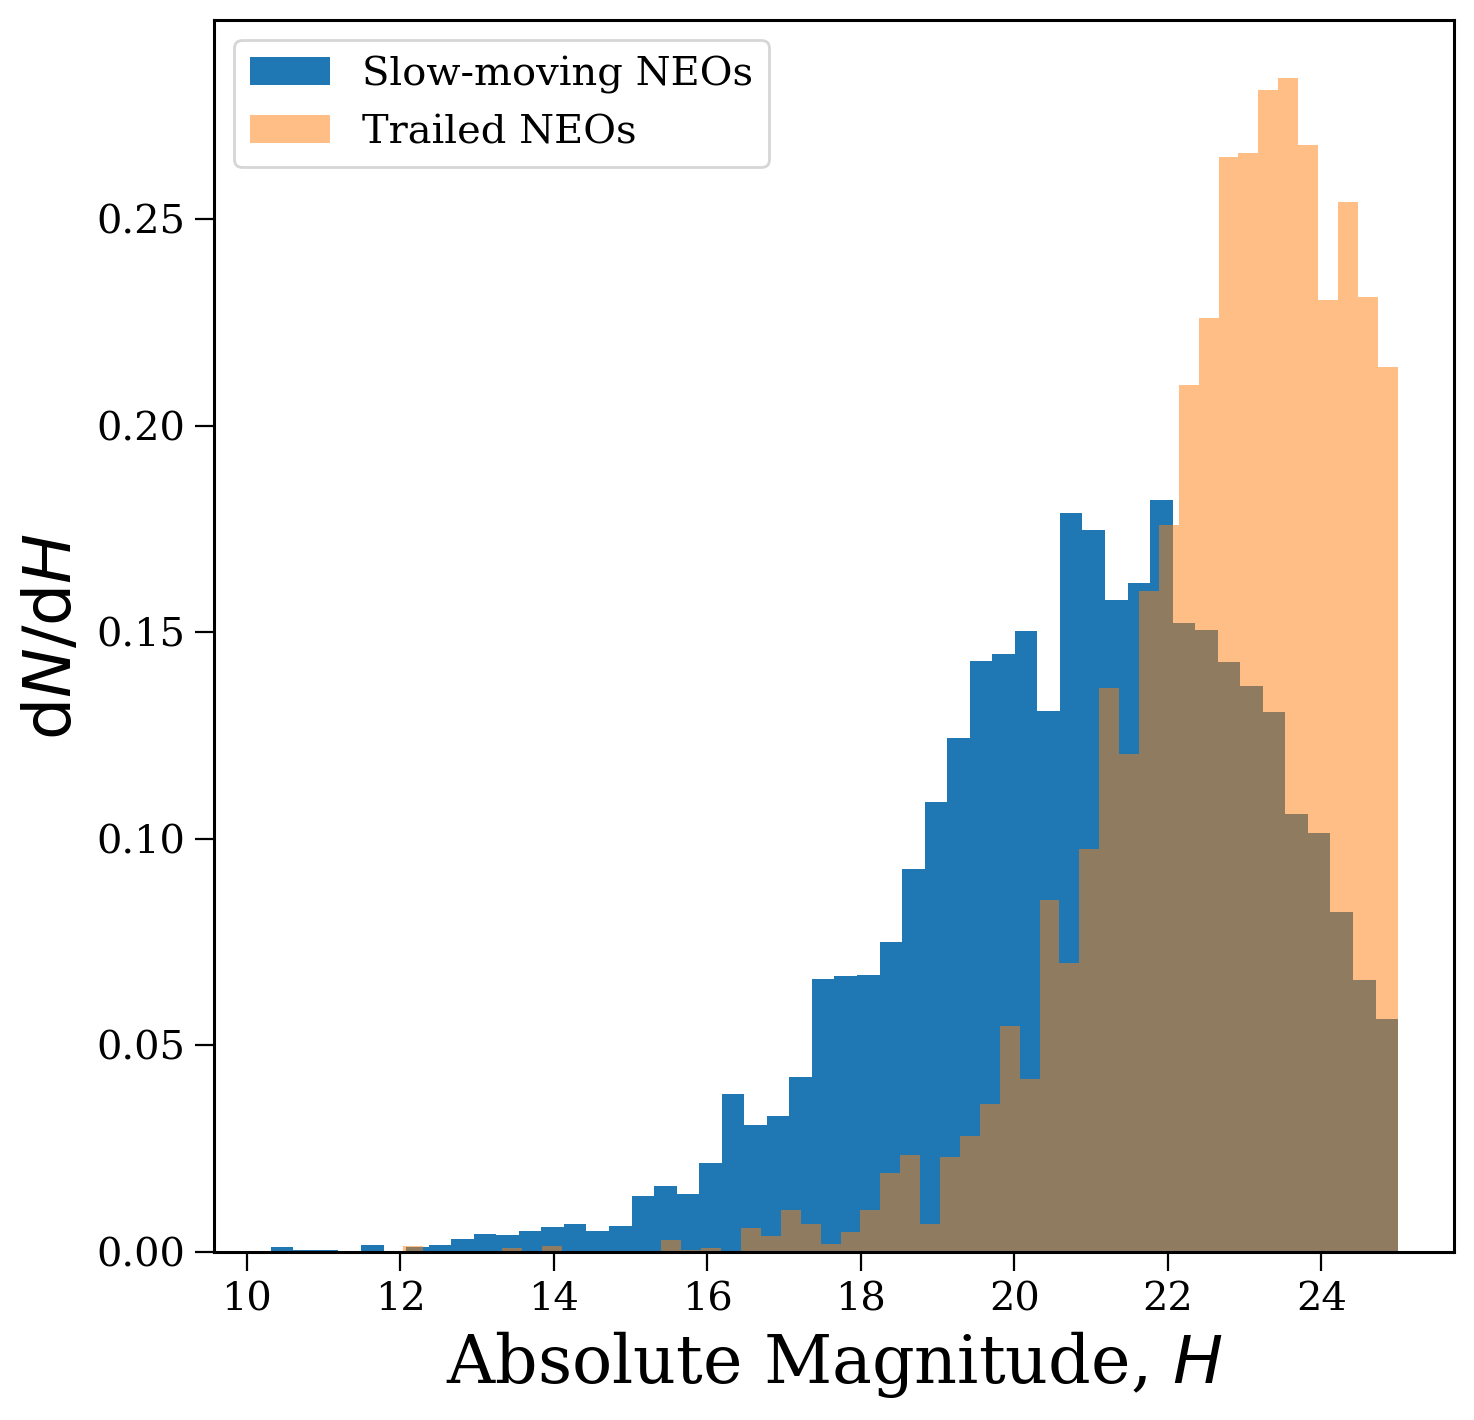

In [39]:
plt.subplots(figsize=(8, 8))

plt.hist(all_neo_H, bins=50, density=True, label="Slow-moving NEOs");
plt.hist(trailed_params["H"], bins=50, density=True, alpha=0.5, label="Trailed NEOs");

plt.xlabel(r"Absolute Magnitude, $H$")
plt.ylabel(r"$\mathrm{d}N/\mathrm{d}H$")

plt.legend(fontsize=0.6*fs)

plt.show()

In [16]:
all_neo_obs_dd

,ObjID,night,FieldMJD,AstRA(deg),AstDec(deg),filter,MaginFilter,AstrometricSigma(mas),PhotometricSigma(mag),n_obs,scores
hex_id,,,,,,,,,,,
000009F,S000002Ea,0,59639.305931,181.910098,-51.215900,r,24.167698,51.100156,0.132554,3,0.0
00000EE,S000003Wa,0,59639.253424,133.971201,-29.924365,i,19.424461,10.235282,0.005782,2,100.0
00000CC,S000003oa,0,59639.050099,103.270354,-58.417879,g,23.015736,23.642197,0.046104,5,100.0
0000240,S000009Aa,0,59639.209257,130.611279,-71.991879,r,22.107977,16.659946,0.031913,2,100.0
0000243,S000009Ea,0,59639.304801,176.652133,-42.573063,r,20.777489,10.518543,0.009212,3,100.0
...,...,...,...,...,...,...,...,...,...,...,...
003EEF2,S00016VOa,377,60016.291527,202.321071,-9.320639,r,23.218937,41.425177,0.118976,2,100.0
004085A,S00018Fta,377,60016.297242,188.221246,-15.217192,r,22.842990,40.017139,0.101279,4,99.0
0040F1A,S000198ha,377,60016.072213,158.555717,16.924966,g,21.844287,21.140696,0.029839,2,100.0


In [7]:
trailed_neos

,ObjID,night
hex_id,,
000095E,S00000DIa,0
0000AE9,S00000Kea,0
000050F,S00000lqa,0
0000686,S00000rHa,0
0001796,S00001C5a,0
...,...,...
003E141,S00015ZTa,377
003ED89,S00016PKa,377
0040F1A,S000198ha,377


# Ecliptic Cutoff

In [168]:
def first_year_stats(neo_obs, mba_obs, cutoff):
    neo_mask = (abs(neo_obs["ecl_lat"]) >= cutoff)
    mba_mask = (abs(mba_obs["ecl_lat"]) >= cutoff)
    n_neo = neo_mask.sum()
    n_mba = mba_mask.sum()
    avg_mag = np.median(np.concatenate((neo_obs["MaginFilter"][neo_mask],
                                        mba_obs["MaginFilter"][mba_mask])))
    return n_neo + n_mba, n_neo / (n_neo + n_mba), avg_mag

In [183]:
%%time
cutoffs = np.linspace(0, abs(min(neo_obs_dd["ecl_lat"])), 1000)
first_year_traffic = np.zeros_like(cutoffs)
first_year_purity = np.zeros_like(cutoffs)

neo_obs_dd_neocp = neo_obs_dd[(neo_obs_dd["ang_vel"] < 1.5) & (neo_obs_dd["scores"] >= 65)]
mba_obs_dd_neocp = mba_obs_dd[mba_obs_dd["scores"] >= 65]

for i in range(len(cutoffs)):
    if i != 0 and i % 100 == 0:
        print(i)
    first_year_traffic[i], first_year_purity[i], _ = first_year_stats(neo_obs_dd_neocp,
                                                                      mba_obs_dd_neocp,
                                                                      cutoffs[i])

100
200
300
400
500
600
700
800
900
CPU times: user 37.4 s, sys: 3.55 s, total: 40.9 s
Wall time: 36.4 s


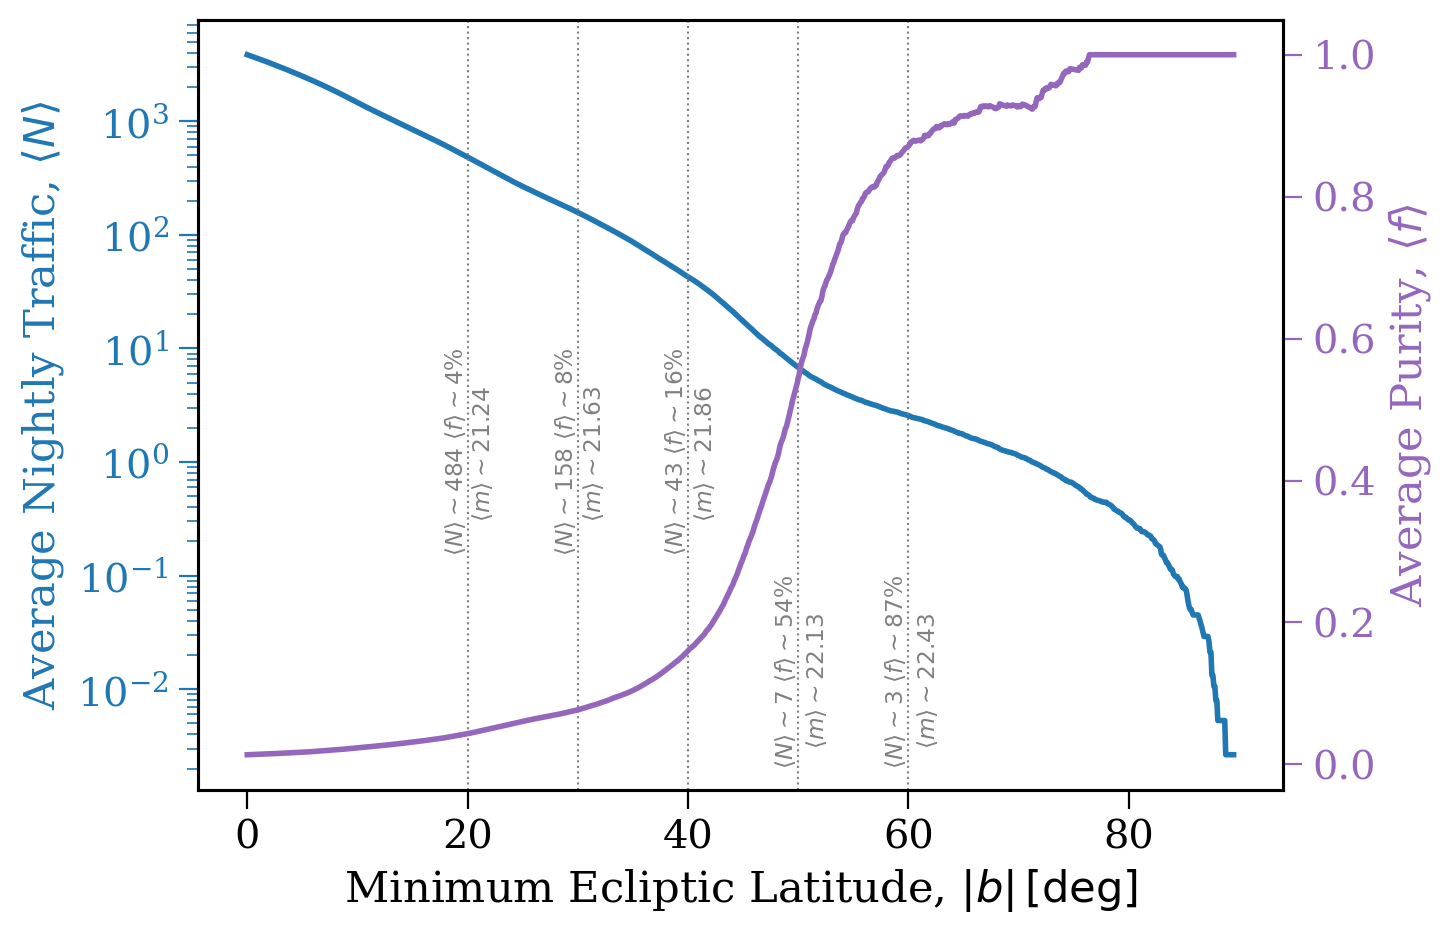

In [188]:
fig, ax = plt.subplots(figsize=(7, 5))

left_col = "tab:blue"
right_col = "tab:purple"

ax.plot(cutoffs, first_year_traffic / 377, lw=2)
ax.set_yscale("log")
ax.set_ylabel(r"Average Nightly Traffic, $\langle N \rangle$", fontsize=0.65*fs, color=left_col)

ax_right = ax.twinx()
ax_right.plot(cutoffs, first_year_purity, color=right_col, lw=2)
ax_right.set_ylabel(r"Average Purity, $\langle f \rangle$", fontsize=0.65*fs, color=right_col)
ax.set_xlabel(r"Minimum Ecliptic Latitude, $|b| \, {\rm [deg]}$", fontsize=0.65*fs)

ax.tick_params(axis="y", which="both", colors=left_col)
ax_right.tick_params(axis="y", which="both", colors=right_col)

for lim in range(20, 60 + 10, 10):
    t, p, am = first_year_stats(neo_obs_dd_neocp, mba_obs_dd_neocp, lim)
    ax.axvline(lim, color="grey", linestyle="dotted", lw=0.75)
    y_val = 2e-3 if lim >= 50 else 1.5e-1
    y_val2 = 3e-3 if lim >= 50 else 3e-1
    ax.annotate(rf"$\langle N \rangle{{\sim}}{{{t / 377:1.0f}}}$ $\langle f \rangle{{\sim}}{{{p*100:1.0f}}}$%",
                xy=(lim, y_val), rotation=90, ha="right", va="bottom", fontsize=0.35*fs, color="grey", zorder=100)
    ax.annotate(rf"$\langle m \rangle{{\sim}}{{{am:1.2f}}}$",
                xy=(lim * 1.01, y_val2), rotation=90, ha="left", va="bottom", fontsize=0.35*fs, color="grey", zorder=100)
    
plt.savefig("../paper/figures/ecliptic_latitude_cutoff.pdf", format="pdf", bbox_inches="tight")
plt.show()